#Summary

The goal of this assignment is to find a binary classification model that predicts the likelihood of someone having a heart disease based on their answers in a survey. The survey contains questions about the respondents sociodemographics such as their age and gender as well as their lifestyle. Some examples for these questions are  "Do you have serious difficulty walking or climbing stairs?" or "Have you smoked at least 100 cigarettes in your entire life?". The target variable for this assignment is whether or not the respondents have ever reported having coronary heart disease (CHD) or myocardial infarction.

The survey responses and the data dictionary are both loaded into a dataframe. In the data understanding stage we check the data for duplicates, investigate the datatypes and correct them if necessary, run descriptive statistics and look at the distribution of the target values as well as null values and outliers.

Then, some univariate visualizations are produced before we present some graphics for each variable against the target variable. In these visualizations some trends can be spotted in the data, for example we see that the distribution of respondents who have ever had a stroke is different among those with a heart disease than for the whole dataset.

Before going into the modelling phase we find an adequate treatment for the outliers and null values. Besides, the categorical variables are encoded using the OneHot and Ordinal encoding methods.

When building and evaluating the model special attention is paid to the Recall score, the model's ability to detect true positives as such. We begin with four different models: a decision tree, a logistic regression, a random forest and a gradient boosting classifier. The logistic regression and the gradient boosting classifier perform significantly better than the other two models, which is why only those two are optimized further.  

Dimensionality reduction has no effect on the performance of both models, only with Resampling the performance metrics improve notably. We also try to see if there are any changes if we reverse the outlier treatment previously done in one category, but afterwards the Recall scores of models increase only by less than 1%.

Even though the gradient boosting classifier ends up having the higher test accuracy the logistic regression is considererd the best-performing model as it has the highest Recall score.

### 0) Import Modules

In [209]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # Series and DataFrames

#import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

#import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

#import sklearn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc


# from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

### 1) Data understanding

#### 1.1 Import dataset and data dictionary

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#define url
url_dict = "/content/drive/MyDrive/SupervisedMachineLearning/data_dictionary.csv"
url_data = "/content/drive/MyDrive/SupervisedMachineLearning/heart_disease_data.csv"

In [4]:
#load data dictionary into df
df_dict = pd.read_csv(url_dict, skipinitialspace=True, usecols=[0,1,2])
df_dict.head()

Variable;Explanation;  \
0                HeartDisease;Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI);   
1                                                                                                         BMI;Body Mass Index (BMI);   
2                             Smoking;Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes];   
3  AlcoholDrinking;Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week;   
4                                                                                            Stroke;(Ever told) (you had) a stroke?;   

  Unnamed: 1 Unnamed: 2  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [5]:
#load survey data into df
df1 = pd.read_csv(url_data)
print("Shape of the dataset: ",df1.shape)
df1.head()

Shape of the dataset:  (319795, 20)


HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No             NaN    Yes             0.0   
2           No  26.58     Yes             NaN     No            20.0   
3           No  24.21      No             NaN     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
0              Yes  Very good        5.0    Yes            No        Yes   
1              Yes  Very good        7.0     No            No         No   
2              Yes       Fair        8.0    Yes            No         No   
3               No       Good        6.0     No            No        Yes   
4              Yes  Very good        8.0     No            No         No   

  HeartDisease_FamilyHistory State  
0                         No    MT  
1                        NaN    VT  
2                        NaN    WY  
3                         No    VT  
4                        NaN    DC

#### 1.2 Check for duplicates

In [6]:
df1.duplicated().sum()

254

The dataframe contains several duplicate rows. But it is known that each row corresponds to a different individual, so these duplicates will not be removed.

#### 1.3 Check datatypes and correct them if necessary

In [7]:
#show datatypes
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HeartDisease                319795 non-null  object 
 1   BMI                         319795 non-null  float64
 2   Smoking                     319795 non-null  object 
 3   AlcoholDrinking             212984 non-null  object 
 4   Stroke                      318683 non-null  object 
 5   PhysicalHealth              319795 non-null  float64
 6   MentalHealth                319795 non-null  float64
 7   DiffWalking                 319795 non-null  object 
 8   Sex                         319795 non-null  object 
 9   AgeCategory                 319795 non-null  object 
 10  Race                        319795 non-null  object 
 11  Diabetic                    319795 non-null  object 
 12  PhysicalActivity            319795 non-null  object 
 13  GenHealth     

There are several columns with datatype "object". Most of them are categorical, but AgeCategory should actually be numeric. The datatype of this column will be changed so that descriptive statistics can be run.

First the unique values in age categories are checked

In [8]:
df1['AgeCategory'].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29', '0'],
      dtype=object)

The age threshold is replaced by average age per group, for example '50-54' becomes 52. '80 or older' becomes 80.

In [9]:
df1['AgeCategory'] = df1['AgeCategory'].replace(['55-59'], (55+59)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['80 or older'], 80)
df1['AgeCategory'] = df1['AgeCategory'].replace(['65-69'], (65+69)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['75-79'], (75+79)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['40-44'], (40+44)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['70-74'], (70+74)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['60-64'], (60+64)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['50-54'], (50+54)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['45-49'], (45+49)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['35-39'], (35+39)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['30-34'], (30+34)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['25-29'], (25+29)/2)
df1['AgeCategory'] = df1['AgeCategory'].replace(['18-24'], (18+24)/2)
df1['AgeCategory'].unique()

array([57.0, 80, 67.0, 77.0, 42.0, 72.0, 62.0, 52.0, 47.0, 21.0, 37.0,
       32.0, 27.0, '0'], dtype=object)

Then, the AgeCategory is converted from an object into a float datatype.

In [10]:
df1['AgeCategory']= df1['AgeCategory'].astype(float)
df1.dtypes

HeartDisease                   object
BMI                           float64
Smoking                        object
AlcoholDrinking                object
Stroke                         object
PhysicalHealth                float64
MentalHealth                  float64
DiffWalking                    object
Sex                            object
AgeCategory                   float64
Race                           object
Diabetic                       object
PhysicalActivity               object
GenHealth                      object
SleepTime                     float64
Asthma                         object
KidneyDisease                  object
SkinCancer                     object
HeartDisease_FamilyHistory     object
State                          object
dtype: object

#### 1.4 Descriptive statistics

First, descriptive statistics are done for numerical values:

In [11]:
df1.describe(include='number')

BMI  PhysicalHealth   MentalHealth   AgeCategory  \
count  319795.000000    319795.00000  319795.000000  319795.00000   
mean       28.327367         3.37171       3.898366      54.34580   
std         6.369381         7.95085       7.955235      17.73441   
min        12.020000         0.00000       0.000000       0.00000   
25%        24.030000         0.00000       0.000000      42.00000   
50%        27.340000         0.00000       0.000000      57.00000   
75%        31.440000         2.00000       3.000000      67.00000   
max       119.000000        30.00000      30.000000      80.00000   

           SleepTime  
count  319795.000000  
mean        7.097075  
std         1.436007  
min         1.000000  
25%         6.000000  
50%         7.000000  
75%         8.000000  
max        24.000000

The maximum values for the BMI and for SleepTime look unlikely, probably outliers. In a chart provided by the US Health Department the maximum BMI value is 54: https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl2.htm Therefore, a BMI of 119 must be impossible. As for SleepTime, it is impossible for someone to sleep on average 24 hours.

The maximum values for Physical Health, Mental Health and AgeCategory seem to be ok since 30 is the possible maximum for Physical Health and Mental Health in the survey, as can be seen in the data dictionary.

In [12]:
print(df_dict.iloc[[5]])

                                    Variable;Explanation;  \
5  PhysicalHealth;Now thinking about your physical health   

                                   Unnamed: 1  \
5  which includes physical illness and injury   

                                                                                  Unnamed: 2  
5  for how many days during the past 30 days was your physical health not good? (0-30 days);  


In [13]:
print(df_dict.iloc[[6]])

                            Variable;Explanation;  \
6  MentalHealth;Thinking about your mental health   

                                                                                Unnamed: 1  \
6  for how many days during the past 30 days was your mental health not good? (0-30 days);   

  Unnamed: 2  
6        NaN  


Now the descriptive statistics are done for categorical values:

In [14]:
df1.describe(include='object').T

count unique        top    freq
HeartDisease                319795      2         No  292422
Smoking                     319795      2         No  187887
AlcoholDrinking             212984      2         No  191207
Stroke                      318683      2         No  306614
DiffWalking                 319795      2         No  275385
Sex                         319795      2     Female  167805
Race                        319795      6      White  245212
Diabetic                    319795      4         No  269653
PhysicalActivity            319795      2        Yes  247957
GenHealth                   319795      5  Very good  113858
Asthma                      319795      2         No  276923
KidneyDisease               319795      2         No  308016
SkinCancer                  319446      2         No  289627
HeartDisease_FamilyHistory   35263      2         No   32008
State                       319795     51         OH    6429

The number of unique values makes sense for all categories, but the ones in the "Diabetic" category should be checked.

In [15]:
df1['Diabetic'].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

#### 1.5 Detection of null values

In [16]:
df1.select_dtypes(include=['object']).isnull().sum()

HeartDisease                       0
Smoking                            0
AlcoholDrinking               106811
Stroke                          1112
DiffWalking                        0
Sex                                0
Race                               0
Diabetic                           0
PhysicalActivity                   0
GenHealth                          0
Asthma                             0
KidneyDisease                      0
SkinCancer                       349
HeartDisease_FamilyHistory    284532
State                              0
dtype: int64

Number of null values in object columns: can be found in columns "AlcoholDrinking", "Stroke", "SkinCancer", "HeartDisease_FamilyHistory".The number of null values seem to be especially high in the "HeartDisease_FamilyHistory" category. To gain more clarity the values are shown as percentages.

In [17]:
df1.select_dtypes(include=['object']).isnull().mean()*100

HeartDisease                   0.000000
Smoking                        0.000000
AlcoholDrinking               33.399834
Stroke                         0.347723
DiffWalking                    0.000000
Sex                            0.000000
Race                           0.000000
Diabetic                       0.000000
PhysicalActivity               0.000000
GenHealth                      0.000000
Asthma                         0.000000
KidneyDisease                  0.000000
SkinCancer                     0.109132
HeartDisease_FamilyHistory    88.973248
State                          0.000000
dtype: float64

When looking at the percentages it becomes clear that in the "AlcoholDrinking" Category about 33% of the values are missing, in the "HeartDisease_FamilyHistory" almost 89% of the values are missing.

In [18]:
df1.select_dtypes(include=['number']).isnull().sum()

BMI               0
PhysicalHealth    0
MentalHealth      0
AgeCategory       0
SleepTime         0
dtype: int64

Number of null values in numerical columns: none

#### 1.6 Distribution of target values

In [19]:
df1['HeartDisease'].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

In [20]:
df1['HeartDisease'].value_counts(normalize=True)*100

HeartDisease
No     91.440454
Yes     8.559546
Name: proportion, dtype: float64

The dataset seems to be imbalanced, the vast majority of respondents have not had a heart disease (over 90 percent)

#### 1.7 Check for outliers

Define outlier testing columns

In [21]:
outlier_testing_cols = ['BMI','PhysicalHealth','MentalHealth', 'AgeCategory','SleepTime']

Define function to detect outliers

In [22]:
def univariate_outliers(s):
    """
    Input: series S
    Output: series with numerical values
    * 2: extreme high outlier
    * 1: moderate high outlier
    * -1: moderate low outlier
    * -2: extreme low outlier
    """
    q1 = s.quantile(q=0.25)
    q3 = s.quantile(q=0.75)
    iqr = q3 - q1
    out = (
        (s > (q3 + 1.5 * iqr)).astype(int)
        + (s > (q3 + 3 * iqr)).astype(int)
        - (s < (q1 - 1.5 * iqr)).astype(int)
        - (s < (q1 - 3 * iqr)).astype(int)
    )
    return out

Run outlier function to create new dataframe with outliers per column

In [23]:
df1_outl_df = pd.DataFrame(
    {
        "outl_" + col: univariate_outliers(df1[col])
        for col in outlier_testing_cols
    }
)

Melt outlier dataframe for better overview

In [24]:
df1_outl_df.melt().reset_index().pivot_table(
    index="variable",
    columns="value",
    values="index",
    aggfunc="count",
    fill_value=0
)

value                  -1       0      1      2
variable                                       
outl_AgeCategory       59  319736      0      0
outl_BMI               44  309612   8818   1321
outl_MentalHealth       0  268219  12650  38926
outl_PhysicalHealth     0  272649   6823  40323
outl_SleepTime       1339  315252   2545    659

There are some moderate low, moderate high and extreme high outliers in the numerical columns

#### 1.8 Visualization of numeric distributions and error detection
- univariate for the whole dataset and
- bivariate in regards to target variable (filtered by heart disease = Yes)

First, the dataframe is filtered by only those values with HeartDisease = Yes

In [25]:
df2 = df1[df1['HeartDisease']=='Yes']
df2.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
5           Yes  28.87     Yes              No     No             6.0   
10          Yes  34.30     Yes              No     No            30.0   
35          Yes  32.98     Yes              No    Yes            10.0   
42          Yes  25.06      No              No     No             0.0   
43          Yes  30.23     Yes              No     No             6.0   

    MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
5            0.0         Yes  Female         77.0  Black       No   
10           0.0         Yes    Male         62.0  White      Yes   
35           0.0         Yes    Male         77.0  White      Yes   
42           0.0         Yes  Female         80.0  White      Yes   
43           2.0         Yes  Female         77.0  White      Yes   

   PhysicalActivity GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
5                No      Fair       12.0     No            No         No   
10               No      Poor       15.0    Yes            No         No   
35              Yes      Poor        4.0     No            No        Yes   
42               No      Good        7.0     No            No        Yes   
43              Yes      Fair        8.0     No           Yes         No   

   HeartDisease_FamilyHistory State  
5                         NaN    PA  
10                        NaN    CA  
35                        NaN    UT  
42                        NaN    IA  
43                        NaN    MO

[Text(0.5, 1.0, 'Distribution for all respondents')]

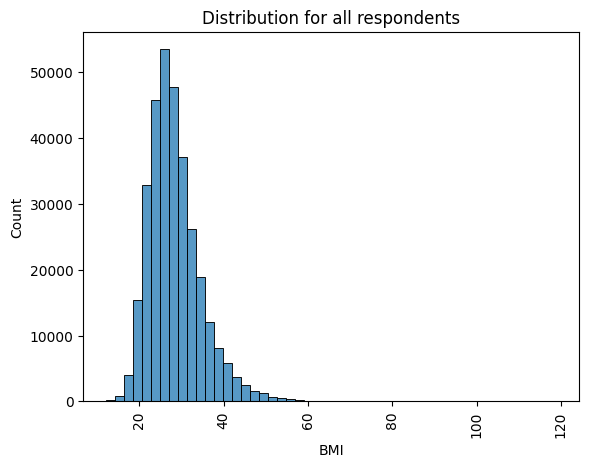

In [26]:
plt.xticks(rotation=90)
ax = sns.histplot(data=df1, x='BMI', bins=50)
ax.set(title="Distribution for all respondents")

[Text(0.5, 1.0, 'Distribution for respondents with heart disease')]

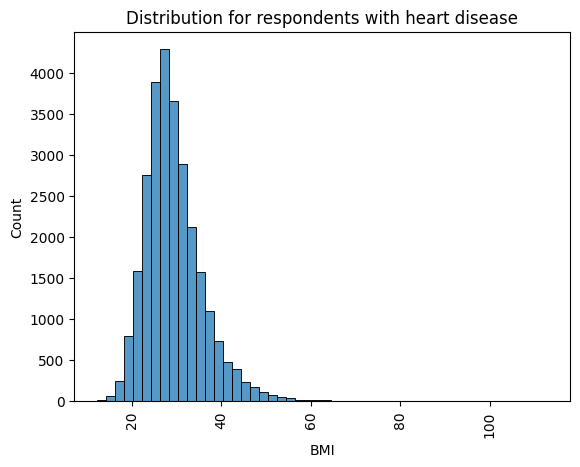

In [27]:
plt.xticks(rotation=90)
ax =sns.histplot(data=df2, x='BMI', bins=50)
ax.set(title="Distribution for respondents with heart disease")

BMI: The distribution for the whole dataset seems to be quite skewed to the left, for respondents with heart disease it looks similar.

[Text(0.5, 1.0, 'Distribution for all respondents')]

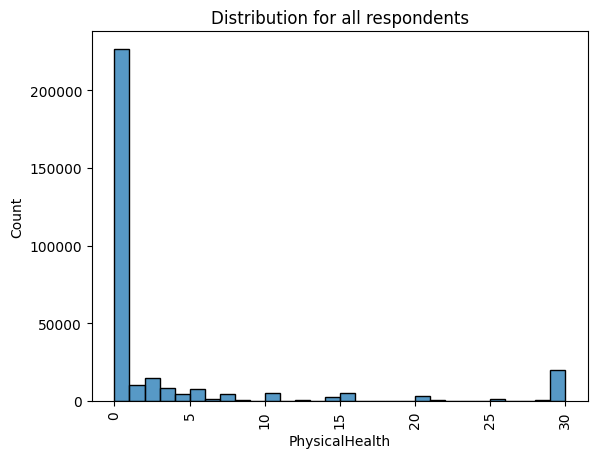

In [28]:
plt.xticks(rotation=90)
ax=sns.histplot(data=df1, x='PhysicalHealth', bins=30)
ax.set(title="Distribution for all respondents")

In [29]:
df1['PhysicalHealth'].value_counts(normalize=True)*100

PhysicalHealth
0.0     70.854454
30.0     6.100471
2.0      4.652981
1.0      3.279914
3.0      2.694539
5.0      2.378399
10.0     1.705155
15.0     1.567254
7.0      1.447490
4.0      1.397145
20.0     1.005644
14.0     0.904642
6.0      0.397129
25.0     0.363983
8.0      0.288935
21.0     0.195750
12.0     0.189184
28.0     0.139464
29.0     0.063791
9.0      0.056286
18.0     0.052221
16.0     0.042215
27.0     0.038775
17.0     0.034397
13.0     0.028456
22.0     0.027830
11.0     0.026580
24.0     0.020951
26.0     0.020638
23.0     0.014384
19.0     0.010945
Name: proportion, dtype: float64

[Text(0.5, 1.0, 'Distribution for respondents with heart disease')]

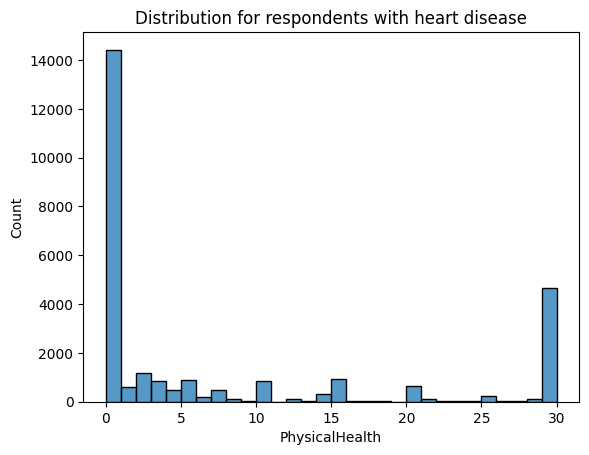

In [30]:
ax=sns.histplot(data=df2, x='PhysicalHealth', bins=30)
ax.set(title="Distribution for respondents with heart disease")

Physical Health: many respondents have not had any issues in the last 30 days. The percentages make this even more clear:
- over 70% of respondents have not had any physical health issues in the last 30 days
- about 6% have had health issues for the entire last 30 days

[Text(0.5, 1.0, 'Distribution for all respondents')]

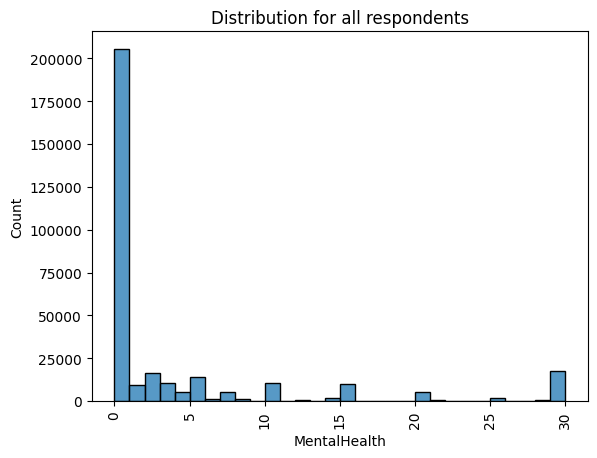

In [31]:
plt.xticks(rotation=90)
ax= sns.histplot(data=df1, x='MentalHealth', bins=30)
ax.set(title="Distribution for all respondents")

In [32]:
df1['MentalHealth'].value_counts(normalize=True)*100

MentalHealth
0.0     64.228959
30.0     5.432543
2.0      5.157992
5.0      4.424397
10.0     3.287419
3.0      3.272722
15.0     3.094482
1.0      2.905299
7.0      1.728607
20.0     1.698275
4.0      1.682015
14.0     0.640410
25.0     0.611016
6.0      0.472177
8.0      0.342094
12.0     0.236714
28.0     0.161041
21.0     0.110071
29.0     0.099126
18.0     0.065980
9.0      0.063478
16.0     0.047530
17.0     0.040026
27.0     0.039400
13.0     0.034397
22.0     0.030645
11.0     0.025954
23.0     0.021264
24.0     0.020951
26.0     0.018449
19.0     0.006567
Name: proportion, dtype: float64

[Text(0.5, 1.0, 'Distribution for respondents with heart disease')]

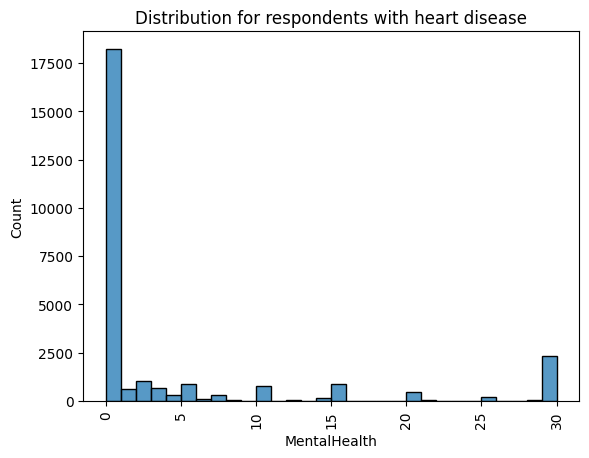

In [33]:
plt.xticks(rotation=90)
ax = sns.histplot(data=df2, x='MentalHealth', bins=30)
ax.set(title="Distribution for respondents with heart disease")

Mental health: Distributions look similar to the one for physical health. Similar to the physical health categories, the share of respondents who reported long-lasting mental health issues in the last 30 days increases a bit when filtering the dataset by heart disease = Yes

[Text(0.5, 1.0, 'Distribution for all respondents')]

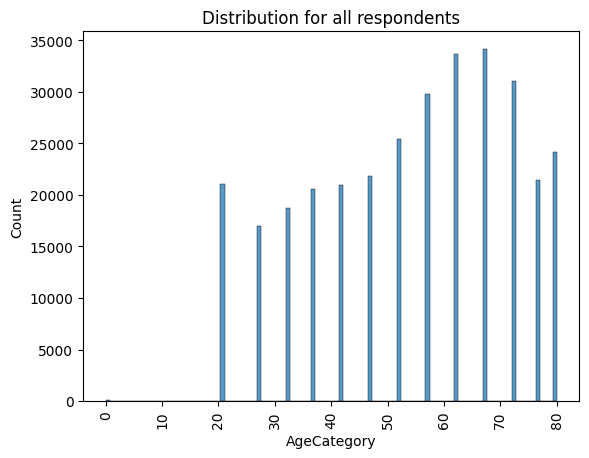

In [34]:
plt.xticks(rotation=90)
ax = sns.histplot(data=df1, x='AgeCategory')
ax.set(title="Distribution for all respondents")

Age: Distribution looks skewed to the right. Also, there seem to be some errors in the data because in some cses the age is 0, but it is not possible for babies to participate in the survey.

In [35]:
df1[df1['AgeCategory']==0]

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
10729            No  28.34      No             NaN    NaN             0.0   
20555            No  25.00     Yes              No     No             0.0   
25036           Yes  25.04     Yes              No     No             2.0   
26062            No  24.03      No              No     No             0.0   
26187            No  20.99      No              No     No             0.0   
28889            No  22.89      No              No     No             0.0   
30796            No  30.43      No              No     No             0.0   
36739            No  28.34      No              No     No             0.0   
48080            No  29.16     Yes              No     No             0.0   
49391            No  23.17     Yes             Yes     No             0.0   
54424            No  23.06      No              No     No            10.0   
66865            No  30.23     Yes              No     No             0.0   
67284            No  28.28     Yes             NaN     No             0.0   
71290            No  18.70      No             NaN     No             0.0   
71327            No  37.66      No              No     No             0.0   
72938            No  25.55      No              No     No            10.0   
89133            No  24.28      No             NaN     No             0.0   
93410            No  23.03      No             NaN     No             1.0   
94377            No  52.46      No             NaN     No             0.0   
104005           No  35.51      No              No     No             0.0   
104103           No  34.46      No             NaN     No             0.0   
104160           No  38.74      No              No     No             0.0   
108390           No  17.43     Yes              No     No            30.0   
110143          Yes  22.87     Yes             NaN     No            14.0   
127724           No  25.11      No              No     No            21.0   
137712           No  22.50     Yes             NaN     No             0.0   
142669           No  36.49     Yes              No     No             1.0   
150963           No  17.43      No              No     No             0.0   
151880           No  35.44      No              No     No             0.0   
152773           No  30.56      No              No     No             0.0   
155833           No  16.92      No              No    Yes            30.0   
157098          Yes  36.46      No              No     No            25.0   
157258           No  27.29     Yes              No     No             0.0   
168915           No  27.46      No              No     No             0.0   
169685          Yes  40.89      No             NaN     No             0.0   
173825           No  29.18      No              No     No             1.0   
174359           No  24.39     Yes              No     No             2.0   
204605           No  22.14      No              No     No             0.0   
206315           No  23.63      No             NaN     No             3.0   
215215           No  28.75      No              No     No             0.0   
220939           No  28.19      No             NaN     No             0.0   
223444           No  25.80      No             Yes     No             0.0   
224024           No  27.98      No              No     No             0.0   
229073           No  38.08     Yes             NaN     No             0.0   
229467           No  25.61      No             Yes     No             1.0   
246729           No  29.53     Yes              No     No             0.0   
249207           No  34.78      No             NaN     No             0.0   
250215           No  24.21      No             NaN     No             0.0   
250854          Yes  30.55     Yes             NaN     No             0.0   
269108           No  34.14      No              No    Yes             0.0   
270016           No  26.29      No              No     No             0.0   
273

When visualizing the rows with Age = 0 they look normal, none of them have only missing values, for example.

Continue visualization of numerical data:

[Text(0.5, 1.0, 'Distribution for respondents with heart disease')]

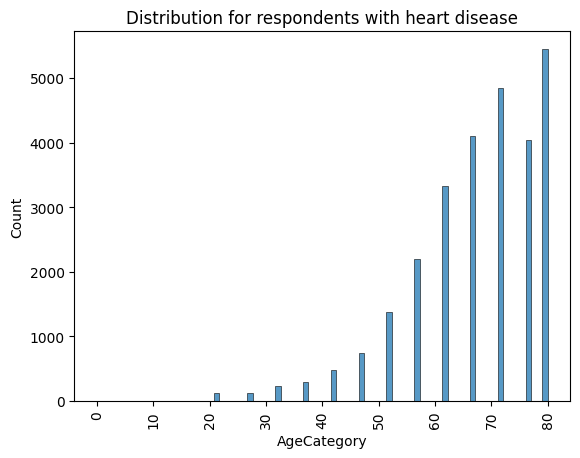

In [36]:
plt.xticks(rotation=90)
ax = sns.histplot(data=df2, x='AgeCategory')
ax.set(title="Distribution for respondents with heart disease")

Age: Distribution for respondents with heart disease is quite different than for the whole dataset, heart disease seems to be more common among older people.

[Text(0.5, 1.0, 'Distribution for all respondents')]

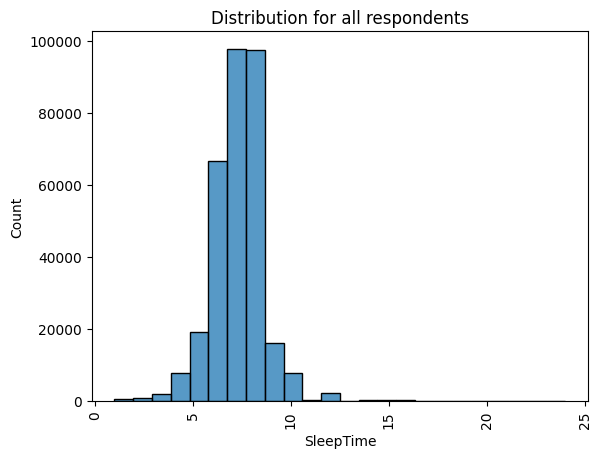

In [37]:
plt.xticks(rotation=90)
ax = sns.histplot(data=df1, x='SleepTime', bins=24)
ax.set(title="Distribution for all respondents")

[Text(0.5, 1.0, 'Distribution for respondents with heart disease')]

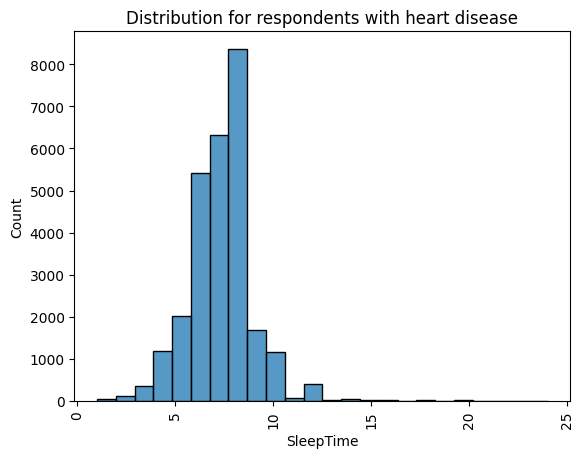

In [38]:
plt.xticks(rotation=90)
ax = sns.histplot(data=df2, x='SleepTime', bins=24)
ax.set(title="Distribution for respondents with heart disease")

SleepTime: As seen during the outlier analysis, this column seems to contain outliers, it is highly unlikely to sleep more than 15 hours per day.

#### 1.8 Visualization of categorical distributions
- univariate for the whole dataset and
- bivariate in regards to target variable (filtered by heart disease = Yes)

First, the target variable is visualized

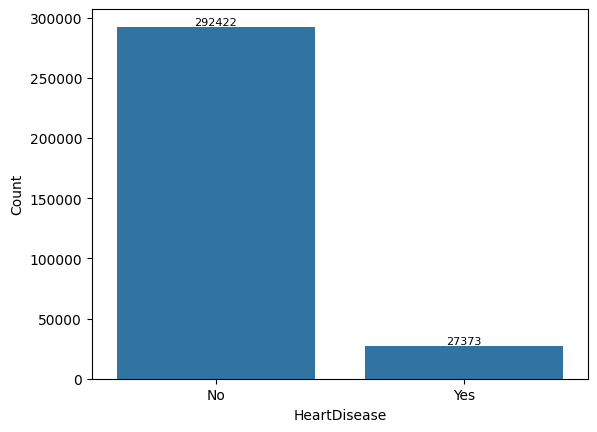

In [39]:
df_new = df1.groupby('HeartDisease')['Smoking'].count().reset_index()
ax = sns.barplot(data=df_new, x='HeartDisease', y ='Smoking')
ax.set_ylabel("Count")
for i in ax.containers:
    ax.bar_label(i,size=8)

As mentioned before, the distribution is quite unbalanced since there are a lot more respondents without than with heart disease.

In [40]:
#function for visualization of remaining variables (whole dataset)
def vis_features(colname,df=df1):
    df_new = df.groupby(colname)['HeartDisease'].count().reset_index()
    ax = sns.barplot(data=df_new, x=colname, y ='HeartDisease')
    ax.set_ylabel("Count")
    ax.set(title='Distribution for all respondents')
    for i in ax.containers:
        ax.bar_label(i,size=8)
    return ax

#function for visualization of remaining variables (respondents with heart disease)
def vis_features2(colname,df=df2):
    df_new = df.groupby(colname)['HeartDisease'].count().reset_index()
    ax = sns.barplot(data=df_new, x=colname, y ='HeartDisease')
    ax.set_ylabel("Count")
    ax.set(title='Distribution for respondents with heart disease')
    for i in ax.containers:
        ax.bar_label(i,size=8)
    return ax

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='Smoking', ylabel='Count'>

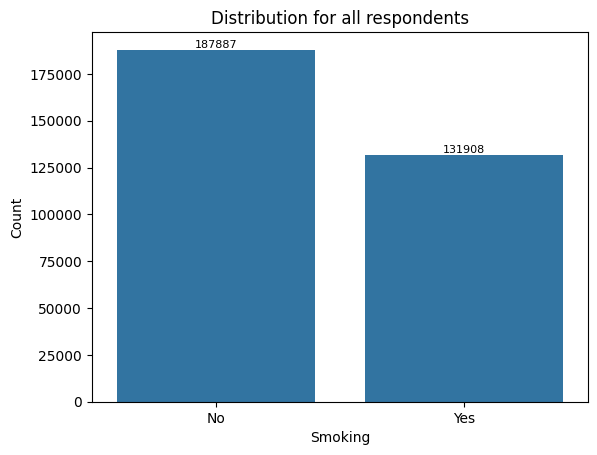

In [41]:
vis_features('Smoking')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='Smoking', ylabel='Count'>

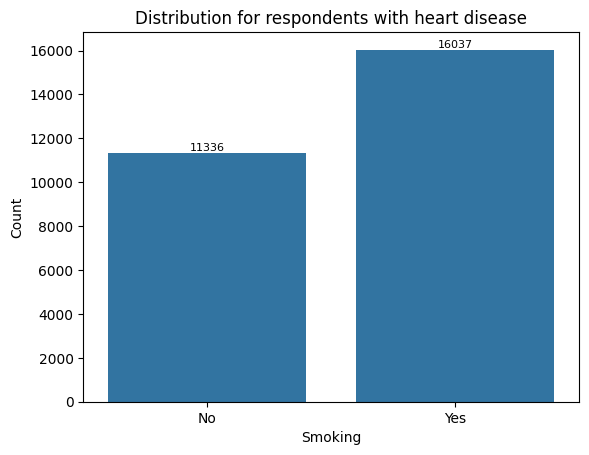

In [42]:
vis_features2('Smoking')

Smoking: Across the whole dataset less than half of the respondents are smokers, among those with heart disease more than half of respondents are smokers.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='AlcoholDrinking', ylabel='Count'>

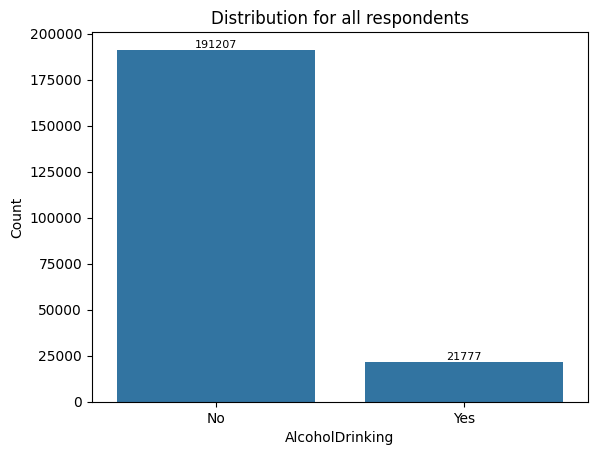

In [43]:
vis_features('AlcoholDrinking')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='AlcoholDrinking', ylabel='Count'>

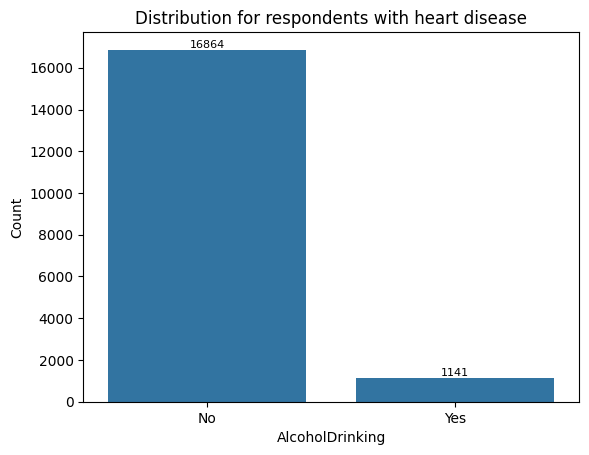

In [44]:
vis_features2('AlcoholDrinking')

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='Stroke', ylabel='Count'>

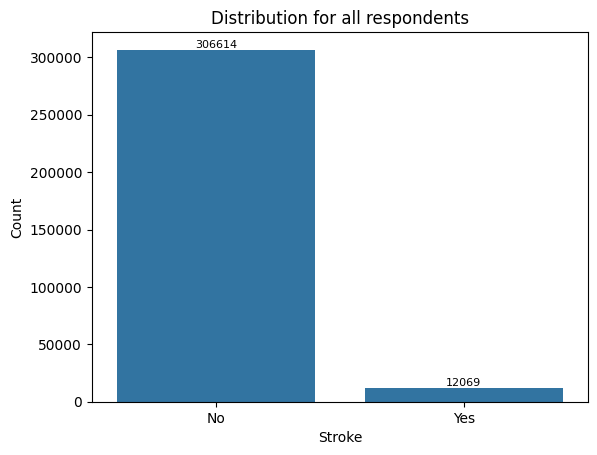

In [45]:
vis_features('Stroke')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='Stroke', ylabel='Count'>

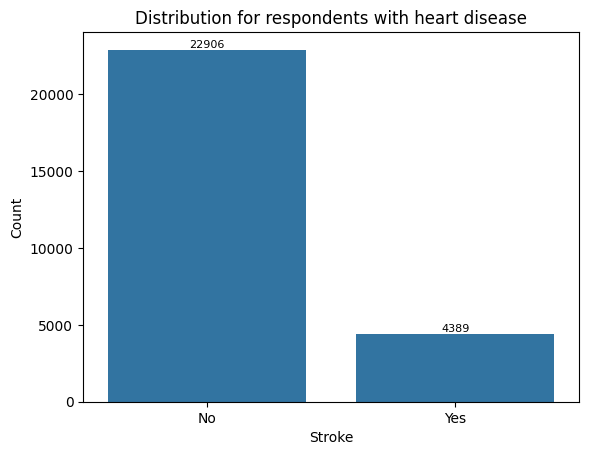

In [46]:
vis_features2('Stroke')

Stroke: Share of respondents who have had a stroke is significatly higher among those who have had a heart disease

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='DiffWalking', ylabel='Count'>

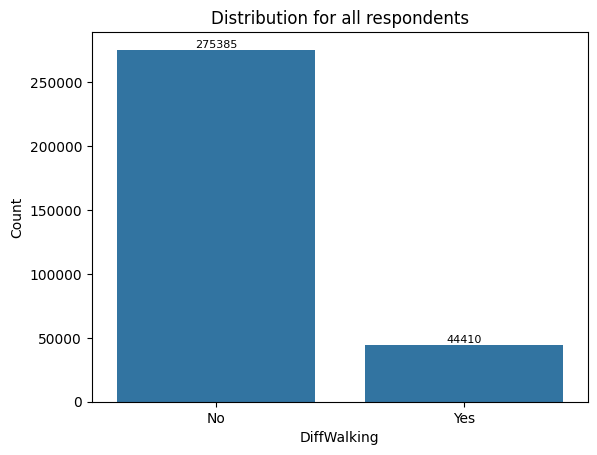

In [47]:
vis_features('DiffWalking')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='DiffWalking', ylabel='Count'>

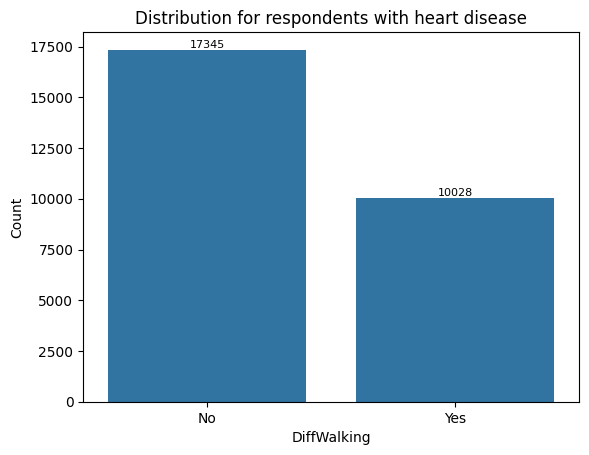

In [48]:
vis_features2('DiffWalking')

Difficulty Walking: Share of respondents who have difficulty walking is higher among those who have had a heart disease, compared to the whole dataset.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='Sex', ylabel='Count'>

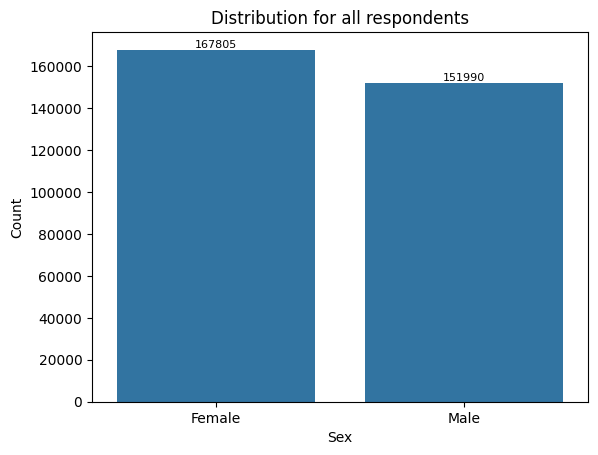

In [49]:
vis_features('Sex')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='Sex', ylabel='Count'>

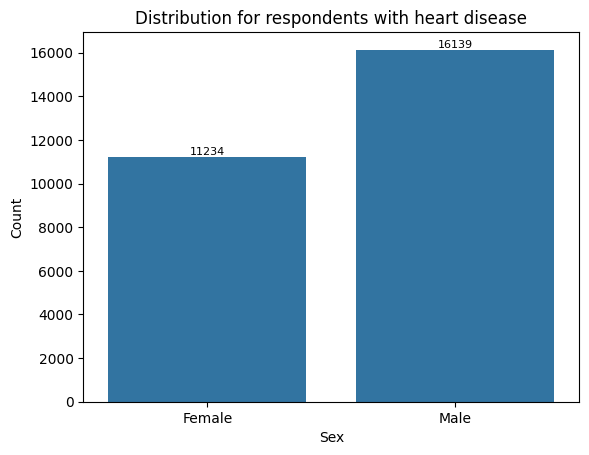

In [50]:
vis_features2('Sex')

Looking at the whole dataset there are slightly more females, but looking at only those with a heart disease the majority is male.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='Race', ylabel='Count'>

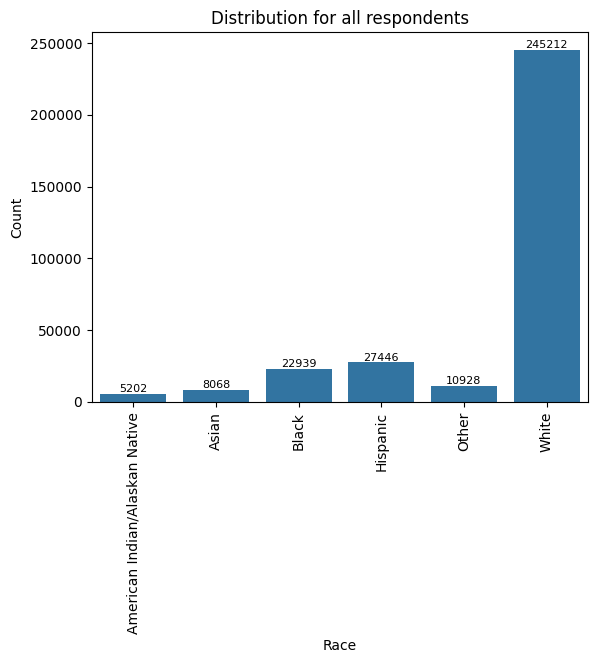

In [51]:
plt.xticks(rotation=90)
vis_features('Race')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='Race', ylabel='Count'>

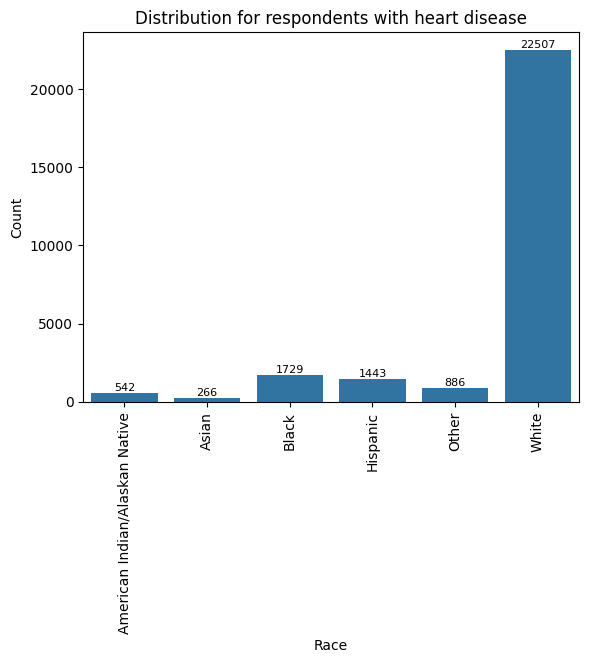

In [52]:
plt.xticks(rotation=90)
vis_features2('Race')

Race: The vast majority of respondents are White.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='Diabetic', ylabel='Count'>

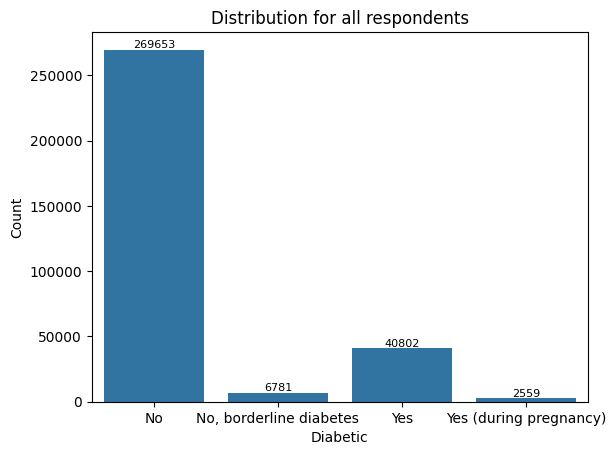

In [53]:
vis_features('Diabetic')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='Diabetic', ylabel='Count'>

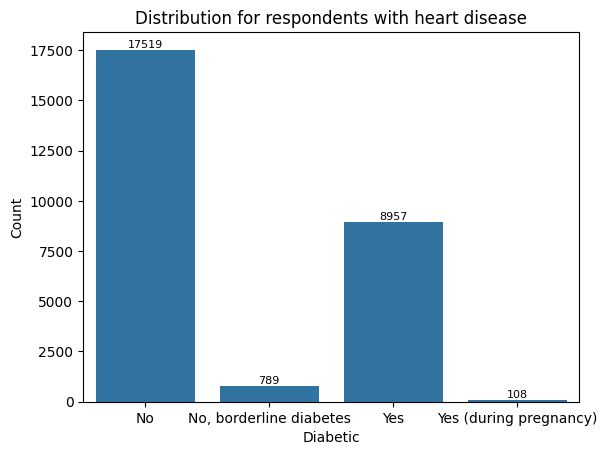

In [54]:
vis_features2('Diabetic')

Diabetic: Share of diabetic respondents is higher among those with a heart disease.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='PhysicalActivity', ylabel='Count'>

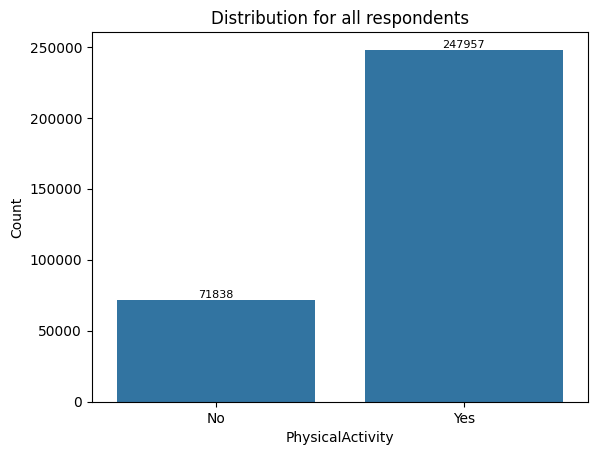

In [55]:
vis_features('PhysicalActivity')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='PhysicalActivity', ylabel='Count'>

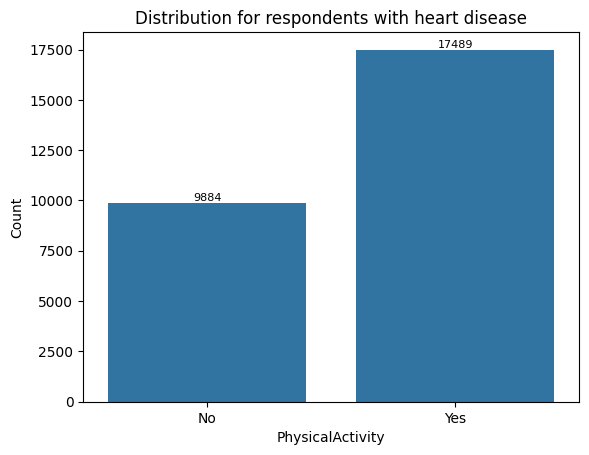

In [56]:
vis_features2('PhysicalActivity')

PhysicalActivity: While the majority of respondents in the survey say that they are physically active, the share of respondents who are not physically active is higher among those with a heart disease.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='GenHealth', ylabel='Count'>

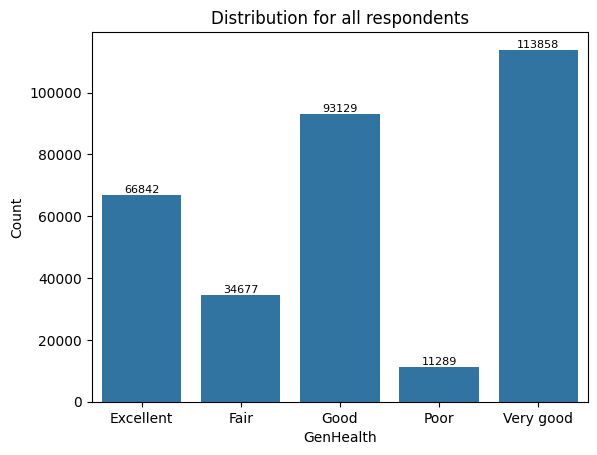

In [57]:
vis_features('GenHealth')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='GenHealth', ylabel='Count'>

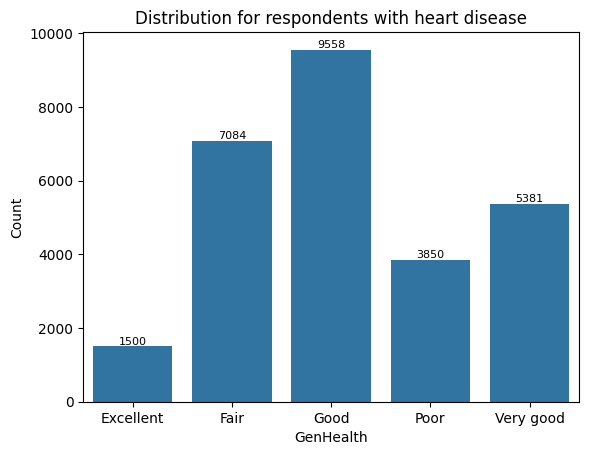

In [58]:
vis_features2('GenHealth')

General Health: The perception of their general health seems to be different among respondents with a heart disease compared to the whole dataset.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='Asthma', ylabel='Count'>

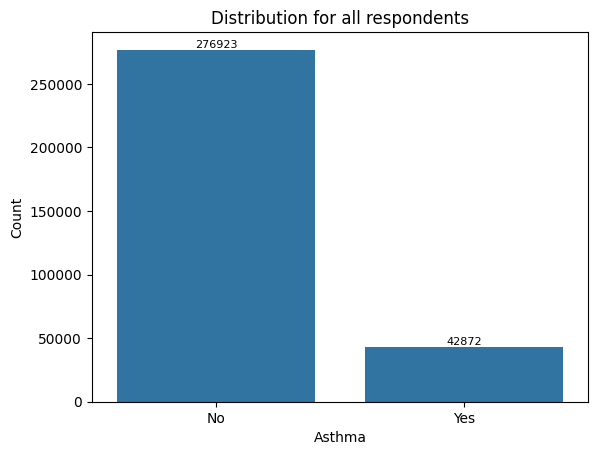

In [59]:
vis_features('Asthma')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='Asthma', ylabel='Count'>

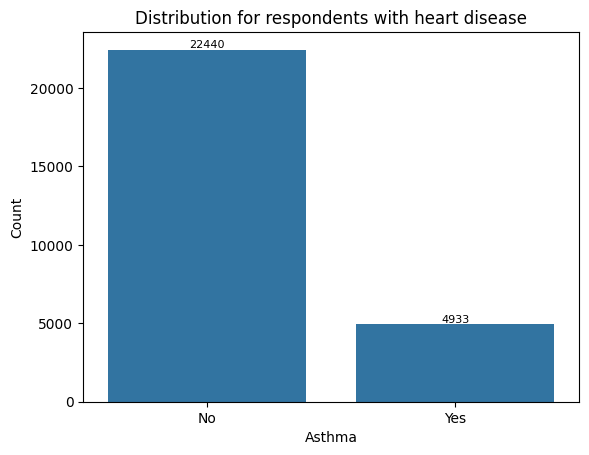

In [60]:
vis_features2('Asthma')

Asthma: Asthma seems to be slightly more common among respondents with a heart disease.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='KidneyDisease', ylabel='Count'>

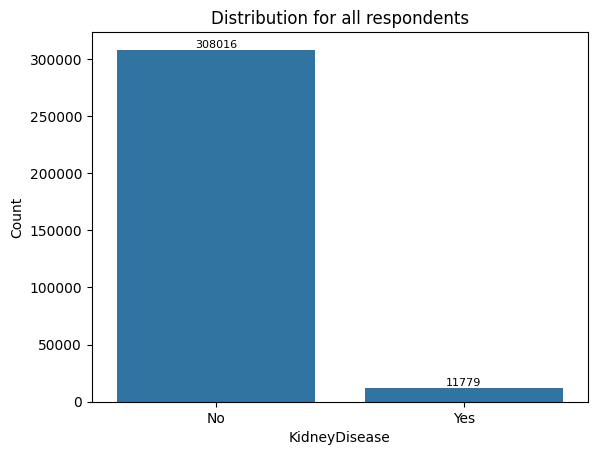

In [61]:
vis_features('KidneyDisease')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='KidneyDisease', ylabel='Count'>

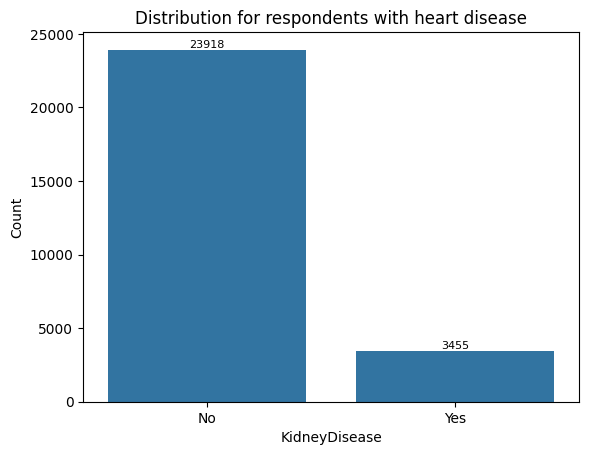

In [62]:
vis_features2('KidneyDisease')

Kidney Disease: Share of respondents with kidney disease is higher among those with a heart disease.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='SkinCancer', ylabel='Count'>

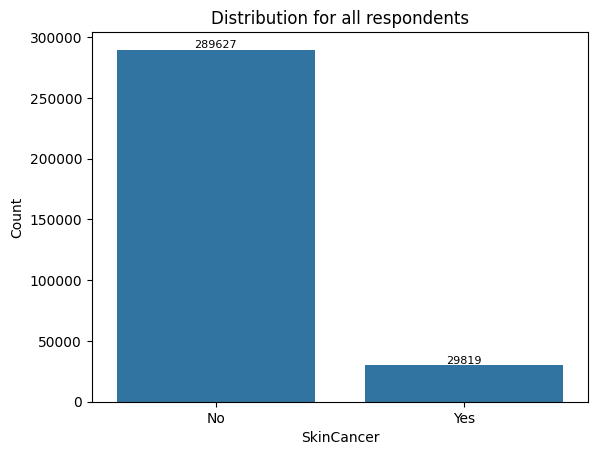

In [63]:
vis_features('SkinCancer')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='SkinCancer', ylabel='Count'>

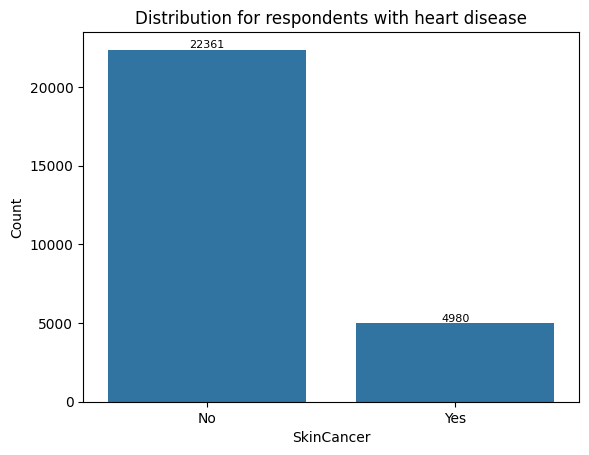

In [64]:
vis_features2('SkinCancer')

Skin Cancer: Share of respondents with skin cancer is higher among those with a heart disease.

<Axes: title={'center': 'Distribution for all respondents'}, xlabel='HeartDisease_FamilyHistory', ylabel='Count'>

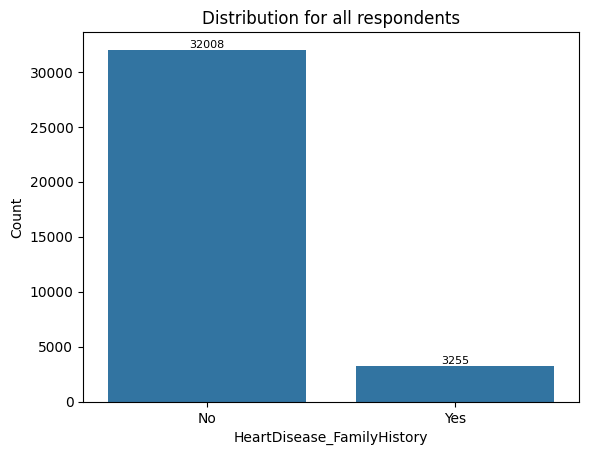

In [65]:
vis_features('HeartDisease_FamilyHistory')

<Axes: title={'center': 'Distribution for respondents with heart disease'}, xlabel='HeartDisease_FamilyHistory', ylabel='Count'>

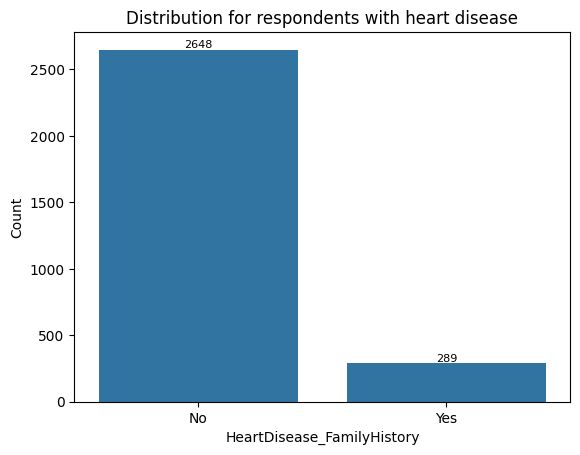

In [66]:
vis_features2('HeartDisease_FamilyHistory')

Text(0, 0.5, 'Count')

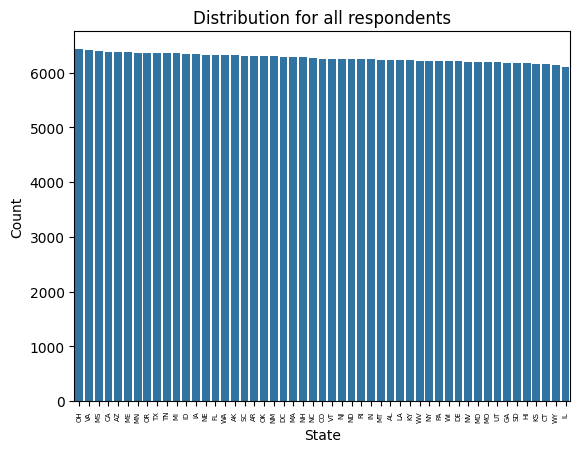

In [67]:
plt.xticks(rotation=90)
plt.xticks(size=5)
df_new = df1.groupby('State')['HeartDisease'].count().sort_values(ascending=False).reset_index()
ax = sns.barplot(data=df_new, x='State', y ='HeartDisease')
ax.set(title='Distribution for all respondents')
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

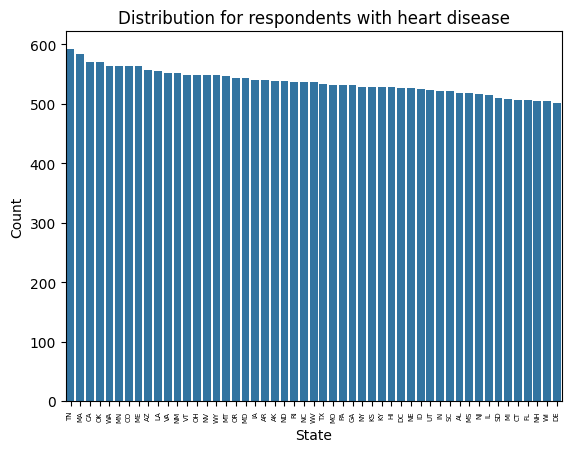

In [68]:
plt.xticks(rotation=90)
plt.xticks(size=5)
df_new = df2.groupby('State')['HeartDisease'].count().sort_values(ascending=False).reset_index()
ax = sns.barplot(data=df_new, x='State', y ='HeartDisease')
ax.set(title='Distribution for respondents with heart disease')
ax.set_ylabel("Count")

States: In general, states seem to be pretty evenly distributed across the dataset. Among respondents with heart disease the distribution of states is also pretty even, but the difference between state 1 and 2 and the rest is clearer.

### 2) Data cleaning

Save to new dataframe before handling the outliers

In [69]:
df3 = df1.copy()
df3.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No             NaN    Yes             0.0   
2           No  26.58     Yes             NaN     No            20.0   
3           No  24.21      No             NaN     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female         57.0  White      Yes   
1           0.0          No  Female         80.0  White       No   
2          30.0          No    Male         67.0  White      Yes   
3           0.0          No  Female         77.0  White       No   
4           0.0         Yes  Female         42.0  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
0              Yes  Very good        5.0    Yes            No        Yes   
1              Yes  Very good        7.0     No            No         No   
2              Yes       Fair        8.0    Yes            No         No   
3               No       Good        6.0     No            No        Yes   
4              Yes  Very good        8.0     No            No         No   

  HeartDisease_FamilyHistory State  
0                         No    MT  
1                        NaN    VT  
2                        NaN    WY  
3                         No    VT  
4                        NaN    DC

#### 2.1 Handling outliers
- AgeCategory: clip moderate low outliers were age = 0 (replace with 20)
- BMI: clipp extreme high outliers (find clipping value)
- SleepTime: clip extreme high outliers (find clipping value)
- MentalHealth and PhysicalHealth: leave as they are

In [70]:
df1_outl_df.head()

outl_BMI  outl_PhysicalHealth  outl_MentalHealth  outl_AgeCategory  \
0         0                    0                  2                 0   
1         0                    0                  0                 0   
2         0                    2                  2                 0   
3         0                    0                  0                 0   
4         0                    2                  0                 0   

   outl_SleepTime  
0               0  
1               0  
2               0  
3               0  
4               0

Concatenate original dataframe with outliers

In [71]:
df3 = pd.concat([df3,df1_outl_df], axis=1)
df3.drop(columns=['outl_PhysicalHealth','outl_MentalHealth'], inplace=True)
df3.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No             NaN    Yes             0.0   
2           No  26.58     Yes             NaN     No            20.0   
3           No  24.21      No             NaN     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female         57.0  White      Yes   
1           0.0          No  Female         80.0  White       No   
2          30.0          No    Male         67.0  White      Yes   
3           0.0          No  Female         77.0  White       No   
4           0.0         Yes  Female         42.0  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
0              Yes  Very good        5.0    Yes            No        Yes   
1              Yes  Very good        7.0     No            No         No   
2              Yes       Fair        8.0    Yes            No         No   
3               No       Good        6.0     No            No        Yes   
4              Yes  Very good        8.0     No            No         No   

  HeartDisease_FamilyHistory State  outl_BMI  outl_AgeCategory  outl_SleepTime  
0                         No    MT         0                 0               0  
1                        NaN    VT         0                 0               0  
2                        NaN    WY         0                 0               0  
3                         No    VT         0                 0               0  
4                        NaN    DC         0                 0               0

Replace moderate low outliers in age category by 20, so there are no more rows with age category = 0

In [72]:
df3.loc[df3['outl_AgeCategory']==-1, 'AgeCategory'] = 20
df3['AgeCategory'].unique()

array([57., 80., 67., 77., 42., 72., 62., 52., 47., 21., 37., 32., 27.,
       20.])

Find clipping value for BMI by excluding the extreme high outliers and then searching for the maximum in the remaining values

In [73]:
df3.loc[df3['outl_BMI']!=2].sort_values(by='BMI', ascending=False).head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
166410           No  53.67      No             NaN     No             3.0   
16044            No  53.67      No             NaN     No            15.0   
18281            No  53.67      No             NaN     No             0.0   
262752           No  53.66     Yes              No     No            26.0   
290350           No  53.66     Yes              No     No             0.0   

        MentalHealth DiffWalking     Sex  AgeCategory      Race Diabetic  \
166410           2.0          No  Female         62.0     White       No   
16044            7.0         Yes  Female         52.0     Black       No   
18281            7.0          No  Female         32.0     White       No   
262752           0.0         Yes  Female         72.0  Hispanic      Yes   
290350           0.0          No    Male         32.0     White       No   

       PhysicalActivity GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
166410               No      Fair        7.0     No            No        Yes   
16044                No      Good        6.0    Yes            No         No   
18281               Yes      Good        4.0     No            No         No   
262752               No      Poor        7.0     No            No         No   
290350               No      Good        7.0     No            No         No   

       HeartDisease_FamilyHistory State  outl_BMI  outl_AgeCategory  \
166410                        NaN    ME         1                 0   
16044                         NaN    KS         1                 0   
18281                         NaN    MI         1                 0   
262752                        NaN    MO         1                 0   
290350                         No    IL         1                 0   

        outl_SleepTime  
166410               0  
16044                0  
18281                0  
262752               0  
290350               0

Take BMI=54 as the clipping value

In [74]:
df3.loc[df3['outl_BMI']==2, 'BMI'] = 54
df3['BMI'].sort_values(ascending=False)

124700    54.00
125648    54.00
277901    54.00
126475    54.00
126491    54.00
          ...  
81754     12.16
51637     12.13
113373    12.08
205511    12.02
69662     12.02
Name: BMI, Length: 319795, dtype: float64

Find clipping value for SleepTime by excluding the extreme high outliers and then searching for the maximum in the remaining values

In [75]:
df3.loc[df3['outl_SleepTime']!=2].sort_values(by='SleepTime', ascending=False).head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
283564           No  47.93     Yes              No     No             1.0   
191653           No  46.00      No              No     No            10.0   
51469            No  54.00      No              No     No             0.0   
152313           No  34.01      No              No     No             0.0   
77861           Yes  41.43     Yes              No    Yes            30.0   

        MentalHealth DiffWalking     Sex  AgeCategory      Race Diabetic  \
283564           1.0         Yes    Male         72.0     White      Yes   
191653          25.0          No  Female         21.0     White       No   
51469            0.0          No    Male         37.0  Hispanic       No   
152313           0.0          No  Female         42.0     Black       No   
77861           30.0         Yes    Male         47.0     White      Yes   

       PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
283564               No       Poor       14.0     No            No         No   
191653              Yes       Fair       14.0     No            No         No   
51469               Yes  Excellent       14.0    Yes            No         No   
152313              Yes       Good       14.0     No            No         No   
77861               Yes       Fair       14.0     No            No         No   

       HeartDisease_FamilyHistory State  outl_BMI  outl_AgeCategory  \
283564                        NaN    TN         1                 0   
191653                        NaN    AR         1                 0   
51469                         NaN    SC         2                 0   
152313                        NaN    CO         0                 0   
77861                          No    ID         0                 0   

        outl_SleepTime  
283564               1  
191653               1  
51469                1  
152313               1  
77861                1

Take SleepTime=15 as the clipping value

In [76]:
df3.loc[df3['outl_SleepTime']==2, 'SleepTime'] = 15
df3['SleepTime'].sort_values(ascending=False)

75968     15.0
192172    15.0
12339     15.0
40685     15.0
270428    15.0
          ... 
226196     1.0
36243      1.0
146846     1.0
267362     1.0
309331     1.0
Name: SleepTime, Length: 319795, dtype: float64

Run describe method to check distributions after some outliers were removed

In [77]:
df3.describe(include='number')

BMI  PhysicalHealth   MentalHealth   AgeCategory  \
count  319795.000000    319795.00000  319795.000000  319795.00000   
mean       28.300079         3.37171       3.898366      54.34949   
std         6.222523         7.95085       7.955235      17.72518   
min        12.020000         0.00000       0.000000      20.00000   
25%        24.030000         0.00000       0.000000      42.00000   
50%        27.340000         0.00000       0.000000      57.00000   
75%        31.440000         2.00000       3.000000      67.00000   
max        54.000000        30.00000      30.000000      80.00000   

           SleepTime       outl_BMI  outl_AgeCategory  outl_SleepTime  
count  319795.000000  319795.000000     319795.000000   319795.000000  
mean        7.093056       0.035698         -0.000184        0.007893  
std         1.407040       0.207269          0.013582        0.142569  
min         1.000000      -1.000000         -1.000000       -1.000000  
25%         6.000000       0.000000          0.000000        0.000000  
50%         7.000000       0.000000          0.000000        0.000000  
75%         8.000000       0.000000          0.000000        0.000000  
max        15.000000       2.000000          0.000000        2.000000

Drop outlier columns again and save result to new dataframe

In [78]:
df4 = df3.drop(columns=['outl_BMI','outl_AgeCategory','outl_SleepTime'])
df4.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No             NaN    Yes             0.0   
2           No  26.58     Yes             NaN     No            20.0   
3           No  24.21      No             NaN     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female         57.0  White      Yes   
1           0.0          No  Female         80.0  White       No   
2          30.0          No    Male         67.0  White      Yes   
3           0.0          No  Female         77.0  White       No   
4           0.0         Yes  Female         42.0  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
0              Yes  Very good        5.0    Yes            No        Yes   
1              Yes  Very good        7.0     No            No         No   
2              Yes       Fair        8.0    Yes            No         No   
3               No       Good        6.0     No            No        Yes   
4              Yes  Very good        8.0     No            No         No   

  HeartDisease_FamilyHistory State  
0                         No    MT  
1                        NaN    VT  
2                        NaN    WY  
3                         No    VT  
4                        NaN    DC

#### 2.2 Imputation of null values and Encoding
- In the categories AlcoholDrinking, Stroke, SkinCancer and HeartDisease_FamilyHistory the null values are replaced with "Unknown" since there are numerous of them. For example, in the 'HeartDiseasesFamilyHistory' it could be risky to assume that all null-values, which make up about 89% of the data, automatically mean "No".
- Rest of Yes/No categories: 0 and 1
- GenHealth: Ordinal encoding('Excellent'=4, 'Poor'=0)
- Rest of categorical values: OneHot Encoding

In [79]:
df4['HeartDisease']= df4['HeartDisease'].replace({'No': 0, 'Yes': 1})
df4['HeartDisease'].unique()

array([0, 1])

In [80]:
df4['Smoking']= df4['Smoking'].replace({'No': 0, 'Yes': 1})
df4['Smoking'].unique()

array([1, 0])

In [81]:
df4['AlcoholDrinking']= df4['AlcoholDrinking'].replace({'No': 'AlcoholDrinkingNo', 'Yes': 'AlcoholDrinkingYes'})
df4['AlcoholDrinking'].fillna("AlcoholDrinkingUnknown", inplace=True)
df4['AlcoholDrinking'].unique()

array(['AlcoholDrinkingNo', 'AlcoholDrinkingUnknown',
       'AlcoholDrinkingYes'], dtype=object)

In [82]:
df4['Stroke']= df4['Stroke'].replace({'No': 'StrokeNo', 'Yes': 'StrokeYes'})
df4['Stroke'].fillna("StrokeUnknown", inplace=True)
df4['Stroke'].unique()

array(['StrokeNo', 'StrokeYes', 'StrokeUnknown'], dtype=object)

In [83]:
df4['DiffWalking']= df4['DiffWalking'].replace({'No': 0, 'Yes': 1})
df4['DiffWalking'].unique()

array([0, 1])

In [84]:
df4['PhysicalActivity']= df4['PhysicalActivity'].replace({'No': 0, 'Yes': 1})
df4['PhysicalActivity'].unique()

array([1, 0])

In [85]:
df4['Asthma']= df4['Asthma'].replace({'No': 0, 'Yes': 1})
df4['Asthma'].unique()

array([1, 0])

In [86]:
df4['KidneyDisease']= df4['KidneyDisease'].replace({'No': 0, 'Yes': 1})
df4['KidneyDisease'].unique()

array([0, 1])

In [87]:
df4['SkinCancer']= df4['SkinCancer'].replace({'No': 'SkinCancerNo', 'Yes': 'SkinCancerYes'})
df4['SkinCancer'].fillna("SkinCancerUnknown", inplace=True)
df4['SkinCancer'].unique()

array(['SkinCancerYes', 'SkinCancerNo', 'SkinCancerUnknown'], dtype=object)

In [88]:
df4['HeartDisease_FamilyHistory']= df4['HeartDisease_FamilyHistory'].replace({'No': 'HeartDisease_FamilyNo', 'Yes': 'HeartDisease_FamilyYes'})
df4['HeartDisease_FamilyHistory'].fillna("HeartDisease_FamilyUnknown", inplace=True)
df4['HeartDisease_FamilyHistory'].unique()

array(['HeartDisease_FamilyNo', 'HeartDisease_FamilyUnknown',
       'HeartDisease_FamilyYes'], dtype=object)

In [89]:
df4['GenHealth']= df4['GenHealth'].replace({'Poor': 0, 'Fair': 1, 'Good':2, 'Very good':3, 'Excellent':4})
df4['GenHealth'].unique()

array([3, 1, 2, 0, 4])

Prepare OneHotEncoder

In [90]:
my_ohe = OneHotEncoder(sparse_output=False)
def category_enc (x):
    ohe = my_ohe.fit_transform(df4[[x]])
    enc = pd.DataFrame(ohe, columns=my_ohe.categories_[0],index=df4.index).astype(int)
    return enc

Perform OneHotEncoding with remaining values

In [91]:
alc_enc = category_enc ('AlcoholDrinking')
alc_enc.head(10)

AlcoholDrinkingNo  AlcoholDrinkingUnknown  AlcoholDrinkingYes
0                  1                       0                   0
1                  0                       1                   0
2                  0                       1                   0
3                  0                       1                   0
4                  1                       0                   0
5                  1                       0                   0
6                  1                       0                   0
7                  1                       0                   0
8                  1                       0                   0
9                  1                       0                   0

In [92]:
stroke_enc = category_enc ('Stroke')
stroke_enc.head(10)

StrokeNo  StrokeUnknown  StrokeYes
0         1              0          0
1         0              0          1
2         1              0          0
3         1              0          0
4         1              0          0
5         1              0          0
6         1              0          0
7         1              0          0
8         1              0          0
9         1              0          0

In [93]:
skincancer_enc = category_enc ('SkinCancer')
skincancer_enc.head(10)

SkinCancerNo  SkinCancerUnknown  SkinCancerYes
0             0                  0              1
1             1                  0              0
2             1                  0              0
3             0                  0              1
4             1                  0              0
5             1                  0              0
6             0                  0              1
7             1                  0              0
8             1                  0              0
9             1                  0              0

In [94]:
disease_fam_enc = category_enc ('HeartDisease_FamilyHistory')
disease_fam_enc.head(10)

HeartDisease_FamilyNo  HeartDisease_FamilyUnknown  HeartDisease_FamilyYes
0                      1                           0                       0
1                      0                           1                       0
2                      0                           1                       0
3                      1                           0                       0
4                      0                           1                       0
5                      0                           1                       0
6                      0                           1                       0
7                      0                           1                       0
8                      0                           1                       0
9                      0                           1                       0

In [95]:
sex_enc = category_enc('Sex')
sex_enc.head(10)

Female  Male
0       1     0
1       1     0
2       0     1
3       1     0
4       1     0
5       1     0
6       1     0
7       1     0
8       1     0
9       0     1

In [96]:
race_enc = category_enc('Race')
race_enc.head(10)

American Indian/Alaskan Native  Asian  Black  Hispanic  Other  White
0                               0      0      0         0      0      1
1                               0      0      0         0      0      1
2                               0      0      0         0      0      1
3                               0      0      0         0      0      1
4                               0      0      0         0      0      1
5                               0      0      1         0      0      0
6                               0      0      0         0      0      1
7                               0      0      0         0      0      1
8                               0      0      0         0      0      1
9                               0      0      0         0      0      1

In [97]:
#rename column 'Other' to avoid confusion later
race_enc.rename(columns={'Other':'Race-Other'}, inplace=True)
race_enc.head()

American Indian/Alaskan Native  Asian  Black  Hispanic  Race-Other  White
0                               0      0      0         0           0      1
1                               0      0      0         0           0      1
2                               0      0      0         0           0      1
3                               0      0      0         0           0      1
4                               0      0      0         0           0      1

In [98]:
diabetic_enc = category_enc('Diabetic')
diabetic_enc.head(10)

No  No, borderline diabetes  Yes  Yes (during pregnancy)
0   0                        0    1                       0
1   1                        0    0                       0
2   0                        0    1                       0
3   1                        0    0                       0
4   1                        0    0                       0
5   1                        0    0                       0
6   1                        0    0                       0
7   0                        0    1                       0
8   0                        1    0                       0
9   1                        0    0                       0

In [99]:
#rename columns to avoid confusion later
diabetic_enc.columns=['Diabetic-No', 'Diabetic-No, borderline', 'Diabetic-Yes', 'Diabetic-Yes (during pregnancy)']
diabetic_enc.head()

Diabetic-No  Diabetic-No, borderline  Diabetic-Yes  \
0            0                        0             1   
1            1                        0             0   
2            0                        0             1   
3            1                        0             0   
4            1                        0             0   

   Diabetic-Yes (during pregnancy)  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0

In [100]:
state_enc = category_enc('State')
state_enc.head(5)

AK  AL  AR  AZ  CA  CO  CT  DC  DE  FL  GA  HI  IA  ID  IL  IN  KS  KY  LA  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   

   MA  MD  ME  MI  MN  MO  MS  MT  NC  ND  NE  NH  NJ  NM  NV  NY  OH  OK  OR  \
0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   PA  RI  SC  SD  TN  TX  UT  VA  VT  WA  WI  WV  WY  
0   0   0   0   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   0   1   0   0   0   0  
2   0   0   0   0   0   0   0   0   0   0   0   0   1  
3   0   0   0   0   0   0   0   0   1   0   0   0   0  
4   0   0   0   0   0   0   0   0   0   0   0   0   0

Concat original df and encoded dfs

In [101]:
df5 = pd.concat([df4, alc_enc, stroke_enc, skincancer_enc, sex_enc, disease_fam_enc, race_enc, diabetic_enc, state_enc], axis=1)
df5.head()

HeartDisease    BMI  Smoking         AlcoholDrinking     Stroke  \
0             0  16.60        1       AlcoholDrinkingNo   StrokeNo   
1             0  20.34        0  AlcoholDrinkingUnknown  StrokeYes   
2             0  26.58        1  AlcoholDrinkingUnknown   StrokeNo   
3             0  24.21        0  AlcoholDrinkingUnknown   StrokeNo   
4             0  23.71        0       AlcoholDrinkingNo   StrokeNo   

   PhysicalHealth  MentalHealth  DiffWalking     Sex  AgeCategory   Race  \
0             3.0          30.0            0  Female         57.0  White   
1             0.0           0.0            0  Female         80.0  White   
2            20.0          30.0            0    Male         67.0  White   
3             0.0           0.0            0  Female         77.0  White   
4            28.0           0.0            1  Female         42.0  White   

  Diabetic  PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0      Yes                 1          3        5.0       1              0   
1       No                 1          3        7.0       0              0   
2      Yes                 1          1        8.0       1              0   
3       No                 0          2        6.0       0              0   
4       No                 1          3        8.0       0              0   

      SkinCancer  HeartDisease_FamilyHistory State  AlcoholDrinkingNo  \
0  SkinCancerYes       HeartDisease_FamilyNo    MT                  1   
1   SkinCancerNo  HeartDisease_FamilyUnknown    VT                  0   
2   SkinCancerNo  HeartDisease_FamilyUnknown    WY                  0   
3  SkinCancerYes       HeartDisease_FamilyNo    VT                  0   
4   SkinCancerNo  HeartDisease_FamilyUnknown    DC                  1   

   AlcoholDrinkingUnknown  AlcoholDrinkingYes  StrokeNo  StrokeUnknown  \
0                       0                   0         1              0   
1                       1                   0         0              0   
2                       1                   0         1              0   
3                       1                   0         1              0   
4                       0                   0         1              0   

   StrokeYes  SkinCancerNo  SkinCancerUnknown  SkinCancerYes  Female  Male  \
0          0             0                  0              1       1     0   
1          1             1                  0              0       1     0   
2          0             1                  0              0       0     1   
3          0             0                  0              1       1     0   
4          0             1                  0              0       1     0   

   HeartDisease_FamilyNo  HeartDisease_FamilyUnknown  HeartDisease_FamilyYes  \
0                      1                           0                       0   
1                      0                           1                       0   
2                      0                           1                       0   
3                      1                           0                       0   
4                      0                           1                       0   

   American Indian/Alaskan Native  Asian  Black  Hispanic  Race-Other  White  \
0                               0      0      0         0           0      1   
1                               0      0      0         0           0      1   
2                               0      0      0         0           0      1   
3                               0      0      0         0           0      1   
4                               0      0      0         0           0      1   

   Diabetic-No  Diabetic-No, borderline  Diabetic-Yes  \
0            0                        0             1   
1            1                        0             0   
2            0                        0             1   
3            1                        0             0   
4            1                        0             0   

   D

In [102]:
print("Shape before column drop:",df5.shape)

Shape before column drop: (319795, 95)


Columns that are no longer needed after encoding are dropped

In [103]:
df6 = df5.drop(columns=['AlcoholDrinking','Stroke','SkinCancer','HeartDisease_FamilyHistory','Sex','Race','Diabetic','State'])
df6.head()

HeartDisease    BMI  Smoking  PhysicalHealth  MentalHealth  DiffWalking  \
0             0  16.60        1             3.0          30.0            0   
1             0  20.34        0             0.0           0.0            0   
2             0  26.58        1            20.0          30.0            0   
3             0  24.21        0             0.0           0.0            0   
4             0  23.71        0            28.0           0.0            1   

   AgeCategory  PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0         57.0                 1          3        5.0       1              0   
1         80.0                 1          3        7.0       0              0   
2         67.0                 1          1        8.0       1              0   
3         77.0                 0          2        6.0       0              0   
4         42.0                 1          3        8.0       0              0   

   AlcoholDrinkingNo  AlcoholDrinkingUnknown  AlcoholDrinkingYes  StrokeNo  \
0                  1                       0                   0         1   
1                  0                       1                   0         0   
2                  0                       1                   0         1   
3                  0                       1                   0         1   
4                  1                       0                   0         1   

   StrokeUnknown  StrokeYes  SkinCancerNo  SkinCancerUnknown  SkinCancerYes  \
0              0          0             0                  0              1   
1              0          1             1                  0              0   
2              0          0             1                  0              0   
3              0          0             0                  0              1   
4              0          0             1                  0              0   

   Female  Male  HeartDisease_FamilyNo  HeartDisease_FamilyUnknown  \
0       1     0                      1                           0   
1       1     0                      0                           1   
2       0     1                      0                           1   
3       1     0                      1                           0   
4       1     0                      0                           1   

   HeartDisease_FamilyYes  American Indian/Alaskan Native  Asian  Black  \
0                       0                               0      0      0   
1                       0                               0      0      0   
2                       0                               0      0      0   
3                       0                               0      0      0   
4                       0                               0      0      0   

   Hispanic  Race-Other  White  Diabetic-No  Diabetic-No, borderline  \
0         0           0      1            0                        0   
1         0           0      1            1                        0   
2         0           0      1            0                        0   
3         0           0      1            1                        0   
4         0           0      1            1                        0   

   Diabetic-Yes  Diabetic-Yes (during pregnancy)  AK  AL  AR  AZ  CA  CO  CT  \
0             1                                0   0   0   0   0   0   0   0   
1             0                                0   0   0   0   0   0   0   0   
2             1                                0   0   0   0   0   0   0   0   
3             0                                0   0   0   0   0   0   0   0   
4             0                                0   0   0   0   0   0   0   0   

   DC  DE  FL  GA  HI  IA  ID  IL  IN  KS  KY  LA  MA  MD  ME  MI  MN  MO  MS  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [104]:
print("Shape after column drop:",df6.shape)

Shape after column drop: (319795, 87)


### 3) Modelling

#### 3.1 Get a first idea of feature correlations with target variable

In [105]:
df_corr = df6.corr()
corr_hd = pd.DataFrame(df_corr['HeartDisease'].T)

Show five factors with highest positive correlation

In [106]:
corr_hd.sort_values(by='HeartDisease', ascending=False).head(6)

HeartDisease
HeartDisease        1.000000
AgeCategory         0.231467
DiffWalking         0.201258
StrokeYes           0.196835
Diabetic-Yes        0.183072
PhysicalHealth      0.170721

Show five factors with highest negative correlation

In [107]:
corr_hd.sort_values(by='HeartDisease', ascending=False).tail(5)

HeartDisease
SkinCancerNo         -0.092913
PhysicalActivity     -0.100030
Diabetic-No          -0.170977
StrokeNo             -0.187725
GenHealth            -0.243182

The correlations make sense for the survey, for example according to these correlations someone is more likely to have a heart disease if their age is higher, and they are less likely to have one if they engage in physical activity.

#### 3.2 Decision Tree

##### 3.2.1 Train/test/validation split

Split validation set

In [108]:
X_train_test, X_val, y_train_test, y_val = model_selection.train_test_split(
    df6.drop('HeartDisease', axis=1),
    df6['HeartDisease'],
    test_size=0.20,
    random_state=42
)

In [109]:
X_train_test.shape

(255836, 86)

In [110]:
X_val.shape

(63959, 86)

Split test set

In [111]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_train_test,
    y_train_test,
    test_size=0.25,
    random_state=42
)

In [112]:
X_train.shape

(191877, 86)

In [113]:
X_test.shape

(63959, 86)

##### 3.2.2 Model building

Instantiate and train decision tree model.

In [114]:
dt = DecisionTreeClassifier(max_depth=4,random_state=42)
dt.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

Visualize decision tree

[Text(0.5, 0.9, 'GenHealth <= 1.5\ngini = 0.155\nsamples = 100.0%\nvalue = [0.915, 0.085]'),
 Text(0.25, 0.7, 'AgeCategory <= 59.5\ngini = 0.363\nsamples = 14.4%\nvalue = [0.762, 0.238]'),
 Text(0.125, 0.5, 'StrokeYes <= 0.5\ngini = 0.223\nsamples = 5.9%\nvalue = [0.872, 0.128]'),
 Text(0.0625, 0.3, 'AgeCategory <= 49.5\ngini = 0.194\nsamples = 5.5%\nvalue = [0.891, 0.109]'),
 Text(0.03125, 0.1, 'gini = 0.12\nsamples = 3.1%\nvalue = [0.936, 0.064]'),
 Text(0.09375, 0.1, 'gini = 0.28\nsamples = 2.4%\nvalue = [0.832, 0.168]'),
 Text(0.1875, 0.3, 'GenHealth <= 0.5\ngini = 0.468\nsamples = 0.4%\nvalue = [0.626, 0.374]'),
 Text(0.15625, 0.1, 'gini = 0.5\nsamples = 0.2%\nvalue = [0.503, 0.497]'),
 Text(0.21875, 0.1, 'gini = 0.422\nsamples = 0.3%\nvalue = [0.697, 0.303]'),
 Text(0.375, 0.5, 'StrokeYes <= 0.5\ngini = 0.432\nsamples = 8.4%\nvalue = [0.685, 0.315]'),
 Text(0.3125, 0.3, 'Male <= 0.5\ngini = 0.405\nsamples = 7.2%\nvalue = [0.718, 0.282]'),
 Text(0.28125, 0.1, 'gini = 0.347\nsample

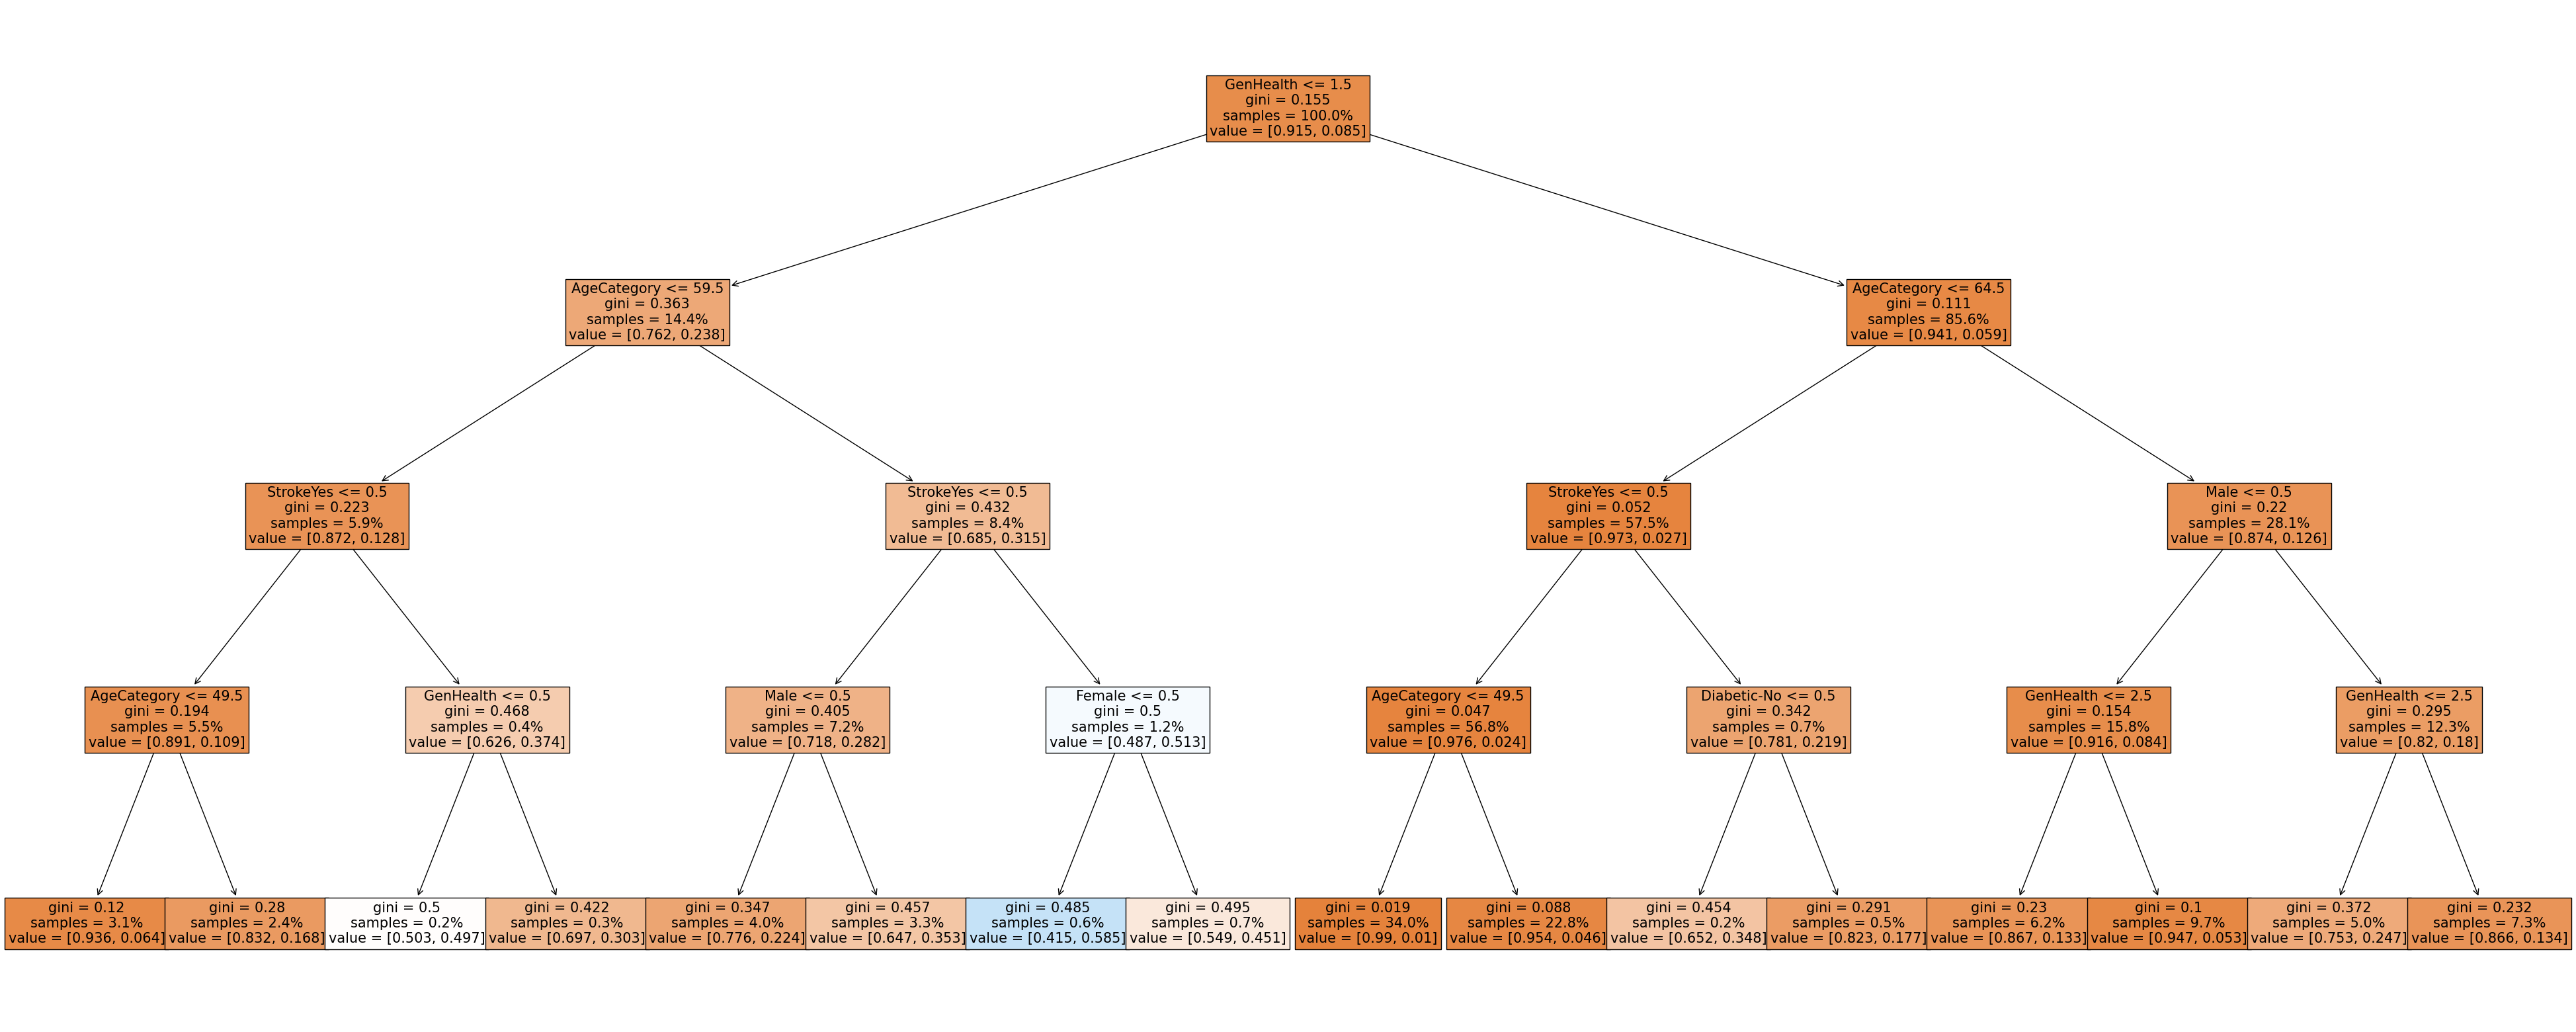

In [115]:
feature_list=list(X_test.columns)
fig, ax = plt.subplots(figsize=(50,20))

tree.plot_tree(dt,
ax = ax,
fontsize = 15,
proportion=True,
filled = True,
feature_names = feature_list
)

In this tree model GenHealth seems to be the most relevant variable as it is the one used for the first split.The is only one scenario where it is more likely to have a heart disease than to not have a heart disease: GenHealth Fair or Poor (0 or 1), AgeCategory above 59.5, Stroke = Yes, Female = No

Feature importance

Text(0.5, 0, 'Random Tree Feature Importance')

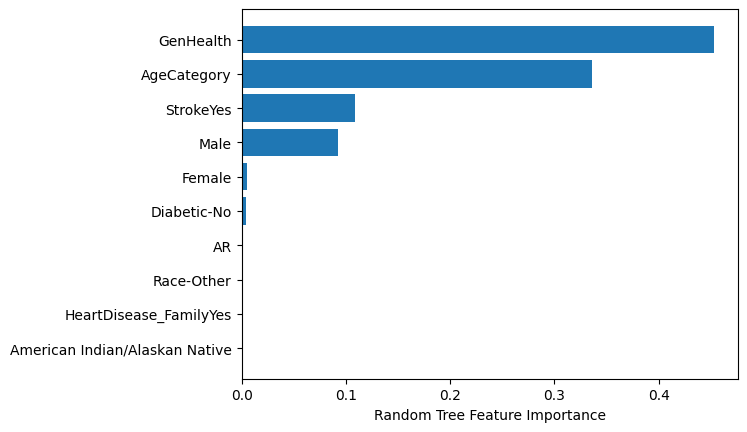

In [116]:
sorted_idx = dt.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Tree Feature Importance")

The feature importance makes sense, looking back at the visualizations.
Among respondents with a heart disease the share of respondents with poor or fair health was significantly higher than for the whole dataset, which explains the importance of the Genhealth feature in this model.

##### 3.2.3 Model evaluation

Get predictions for the training set

In [117]:
#define function for results df creation
def results_eval(mod, x_train, y_train_):
    y_train_df = pd.DataFrame(y_train_)
    y_train_pred = pd.DataFrame(mod.predict(x_train), index=y_train_.index, columns=['HeartDisease Prediction'])
    results_df = y_train_df.join(y_train_pred, how= 'inner')
    results_df['Success'] = (results_df['HeartDisease'] == results_df['HeartDisease Prediction']).astype(int)
    return results_df

In [118]:
results_dt = results_eval(dt, X_train, y_train)
results_dt.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

Show evaluation metrics: Accuracy, Precision, Recall. Special attention should be paid to the Recall values as we are dealing with a medical test, here we need to avoid false negatives. The metrics are not only calculated for the training set but also for the test set to be able to check if there is overfitting on the training set.

In [119]:
def metr(model, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Confusion Matrix for Training Set
    confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
    tn_train, fp_train, fn_train, tp_train = confusion_matrix_train.ravel()

    # Confusion Matrix for Test Set
    confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)
    tn_test, fp_test, fn_test, tp_test = confusion_matrix_test.ravel()

    # Training Metrics
    accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
    precision_train = metrics.precision_score(y_train, y_train_pred)
    recall_train = metrics.recall_score(y_train, y_train_pred)

    # Test Metrics
    accuracy_test = metrics.accuracy_score(y_test, y_test_pred)
    precision_test = metrics.precision_score(y_test, y_test_pred)
    recall_test = metrics.recall_score(y_test, y_test_pred)

    # Print Metrics
    print("Training Confusion Matrix: ")
    print(confusion_matrix_train)
    print(f"TN = {tn_train} - FP = {fp_train} - FN = {fn_train} - TP = {tp_train}\n")

    print("Training Metrics: ")
    print(f"Accuracy: {accuracy_train:.4f}")
    print(f"Precision: {precision_train:.4f}")
    print(f"Recall: {recall_train:.4f}\n")

    print("Test Confusion Matrix: ")
    print(confusion_matrix_test)
    print(f"TN = {tn_test} - FP = {fp_test} - FN = {fn_test} - TP = {tp_test}\n")

    print("Test Metrics: ")
    print(f"Accuracy: {accuracy_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Recall: {recall_test:.4f}\n")

    return  accuracy_train, precision_train, recall_train, accuracy_test, precision_test, recall_test

In [120]:
accuracy_train_dt, precision_train_dt, recall_train_dt, accuracy_test_dt, precision_test_dt, recall_test_dt = metr(dt, X_train, y_train, X_test, y_test)

Training Confusion Matrix: 
[[175134    448]
 [ 15663    632]]
TN = 175134 - FP = 448 - FN = 15663 - TP = 632

Training Metrics: 
Accuracy: 0.9160
Precision: 0.5852
Recall: 0.0388

Test Confusion Matrix: 
[[58327   146]
 [ 5304   182]]
TN = 58327 - FP = 146 - FN = 5304 - TP = 182

Test Metrics: 
Accuracy: 0.9148
Precision: 0.5549
Recall: 0.0332



The Recall of this model is only 3.88% on the training set and 3.32% on the test set. We well try to improve the model by tweaking the parameters before evaluating it further.

##### 3.2.4 Model Optimization

In [121]:
for i in range(1, 10):
    dt = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracy = dt.score(X_train, y_train)
    test_accuracy = dt.score(X_test, y_test)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.9150758037701235 - Test: 0.9142263012242218
Tree max_depth: 2. Train: 0.9150758037701235 - Test: 0.9142263012242218
Tree max_depth: 3. Train: 0.9153885040937684 - Test: 0.9141168561109461
Tree max_depth: 4. Train: 0.916034751429301 - Test: 0.9147891618067825
Tree max_depth: 5. Train: 0.9164204151617964 - Test: 0.915086227114245
Tree max_depth: 6. Train: 0.9170718741693897 - Test: 0.9148986069200582
Tree max_depth: 7. Train: 0.9177337565211047 - Test: 0.9146171766287778
Tree max_depth: 8. Train: 0.9186874925082215 - Test: 0.9141637611594928
Tree max_depth: 9. Train: 0.9202718408146886 - Test: 0.9132882002532873


Increase maximum tree depth to 5, that is when we get the highest test Accuracy

In [122]:
dt = DecisionTreeClassifier(max_depth=5,random_state=42)
dt.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [123]:
results_dt = results_eval(dt, X_train, y_train)
results_dt.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [124]:
accuracy_train_dt, precision_train_dt, recall_train_dt, accuracy_test_dt, precision_test_dt, recall_test_dt = metr(dt, X_train, y_train, X_test, y_test)

Training Confusion Matrix: 
[[174893    689]
 [ 15348    947]]
TN = 174893 - FP = 689 - FN = 15348 - TP = 947

Training Metrics: 
Accuracy: 0.9164
Precision: 0.5789
Recall: 0.0581

Test Confusion Matrix: 
[[58239   234]
 [ 5197   289]]
TN = 58239 - FP = 234 - FN = 5197 - TP = 289

Test Metrics: 
Accuracy: 0.9151
Precision: 0.5526
Recall: 0.0527



By increasing the tree depth to 5 the Recall increases to 5.81% on the training set and 5.27% on the test set. With a maximum tree depth higher than 5 the test accuracy goes down (overfitting), so the maximum tree depth will be left at 5.

#### 3.3 Logistic Regression

##### 3.3.1 Train/test/validation split

Before training the logistic regression the dataset will be scaled.:
BMI, Physical Health, Mental Health, Age Category, SleepTime, GenHealth. They will be scaled from 0 to 1 so that the range is the same as for the categorical variables

In [125]:
mmsc = MinMaxScaler()
mm_BMI = mmsc.fit_transform(df6[["BMI"]]).flatten()
mm_PhysicalHealth = mmsc.fit_transform(df6[["PhysicalHealth"]]).flatten()
mm_MentalHealth = mmsc.fit_transform(df6[["MentalHealth"]]).flatten()
mm_AgeCategory = mmsc.fit_transform(df6[["AgeCategory"]]).flatten()
mm_SleepTime = mmsc.fit_transform(df6[["SleepTime"]]).flatten()
mm_GenHealth = mmsc.fit_transform(df6[["GenHealth"]]).flatten()

The current dataframe is copied and the scaled columns are added

In [126]:
df7 = df6.copy()
df7['BMI'] = mm_BMI
df7['PhysicalHealth'] = mm_PhysicalHealth
df7['MentalHealth'] = mm_MentalHealth
df7['AgeCategory'] = mm_AgeCategory
df7['SleepTime'] = mm_SleepTime
df7['GenHealth'] = mm_GenHealth
df7.head()

HeartDisease       BMI  Smoking  PhysicalHealth  MentalHealth  DiffWalking  \
0             0  0.109100        1        0.100000           1.0            0   
1             0  0.198190        0        0.000000           0.0            0   
2             0  0.346832        1        0.666667           1.0            0   
3             0  0.290376        0        0.000000           0.0            0   
4             0  0.278466        0        0.933333           0.0            1   

   AgeCategory  PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0     0.616667                 1       0.75   0.285714       1              0   
1     1.000000                 1       0.75   0.428571       0              0   
2     0.783333                 1       0.25   0.500000       1              0   
3     0.950000                 0       0.50   0.357143       0              0   
4     0.366667                 1       0.75   0.500000       0              0   

   AlcoholDrinkingNo  AlcoholDrinkingUnknown  AlcoholDrinkingYes  StrokeNo  \
0                  1                       0                   0         1   
1                  0                       1                   0         0   
2                  0                       1                   0         1   
3                  0                       1                   0         1   
4                  1                       0                   0         1   

   StrokeUnknown  StrokeYes  SkinCancerNo  SkinCancerUnknown  SkinCancerYes  \
0              0          0             0                  0              1   
1              0          1             1                  0              0   
2              0          0             1                  0              0   
3              0          0             0                  0              1   
4              0          0             1                  0              0   

   Female  Male  HeartDisease_FamilyNo  HeartDisease_FamilyUnknown  \
0       1     0                      1                           0   
1       1     0                      0                           1   
2       0     1                      0                           1   
3       1     0                      1                           0   
4       1     0                      0                           1   

   HeartDisease_FamilyYes  American Indian/Alaskan Native  Asian  Black  \
0                       0                               0      0      0   
1                       0                               0      0      0   
2                       0                               0      0      0   
3                       0                               0      0      0   
4                       0                               0      0      0   

   Hispanic  Race-Other  White  Diabetic-No  Diabetic-No, borderline  \
0         0           0      1            0                        0   
1         0           0      1            1                        0   
2         0           0      1            0                        0   
3         0           0      1            1                        0   
4         0           0      1            1                        0   

   Diabetic-Yes  Diabetic-Yes (during pregnancy)  AK  AL  AR  AZ  CA  CO  CT  \
0             1                                0   0   0   0   0   0   0   0   
1             0                                0   0   0   0   0   0   0   0   
2             1                                0   0   0   0   0   0   0   0   
3             0                                0   0   0   0   0   0   0   0   
4             0                                0   0   0   0   0   0   0   0   

   DC  DE  FL  GA  HI  IA  ID  IL  IN  KS  KY  LA  MA  MD  ME  MI  MN  MO  MS  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   

Split validation set

In [127]:
X_train_test2, X_val2, y_train_test2, y_val2 = model_selection.train_test_split(
    df7.drop('HeartDisease', axis=1),
    df7['HeartDisease'],
    test_size=0.20,
    random_state=42
)

Split test set

In [128]:
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(
    X_train_test2,
    y_train_test2,
    test_size=0.25,
    random_state=42
)

##### 3.3.2 Model building

In [129]:
#build model
logr = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500)
logr.fit(X=X_train2, y=y_train2)

LogisticRegression(max_iter=500, random_state=42)

In [130]:
# get importances
importances = pd.DataFrame(data={
    'Attribute': X_train2.columns,
    'Importance': logr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [131]:
#features with high positive coefficients
importances.head(5)

Attribute  Importance
5     AgeCategory    3.360784
16      StrokeYes    0.732502
10  KidneyDisease    0.582946
0             BMI    0.402956
21           Male    0.363483

In [132]:
#features with high negative coefficients
importances.tail()

Attribute  Importance
26          Asian   -0.323924
8       SleepTime   -0.360665
20         Female   -0.369191
15  StrokeUnknown   -0.467977
7       GenHealth   -1.999589

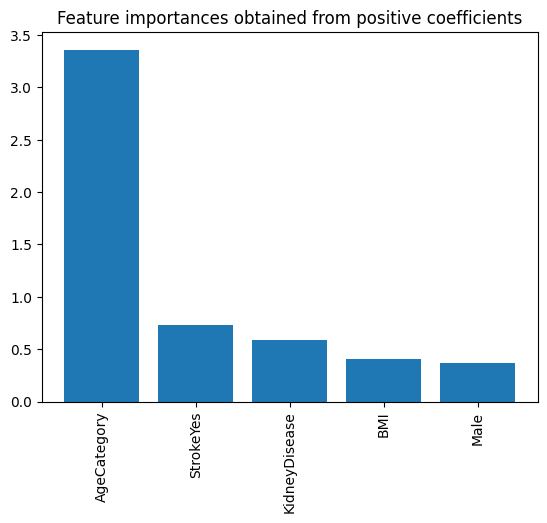

In [133]:
#features with high positive coefficients
plt.bar(x=importances.head()['Attribute'], height=importances.head()['Importance'])
plt.title('Feature importances obtained from positive coefficients')
plt.xticks(rotation='vertical')
plt.show()

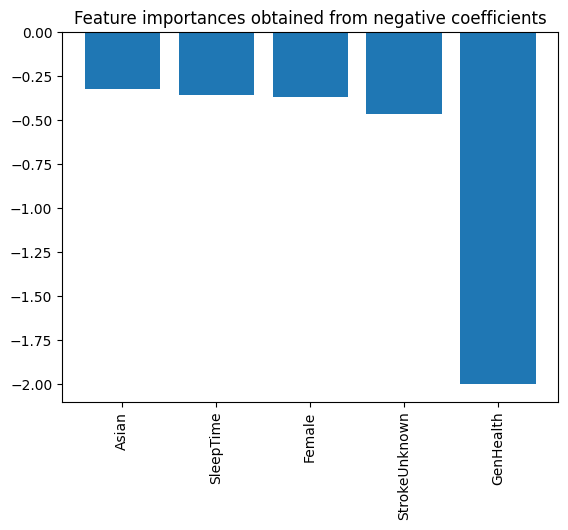

In [134]:
#features with high negative coefficients
plt.bar(x=importances.tail()['Attribute'], height=importances.tail()['Importance'])
plt.title('Feature importances obtained from negative coefficients')
plt.xticks(rotation='vertical')
plt.show()

##### 3.3.3 Model evaluation

In [135]:
results_logr = results_eval(logr, X_train2, y_train2)
results_logr.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [136]:
accuracy_train_logr, precision_train_logr, recall_train_logr, accuracy_test_logr, precision_test_logr, recall_test_logr = metr(logr, X_train2, y_train2, X_test2, y_test2)

Training Confusion Matrix: 
[[174102   1480]
 [ 14453   1842]]
TN = 174102 - FP = 1480 - FN = 14453 - TP = 1842

Training Metrics: 
Accuracy: 0.9170
Precision: 0.5545
Recall: 0.1130

Test Confusion Matrix: 
[[57952   521]
 [ 4919   567]]
TN = 57952 - FP = 521 - FN = 4919 - TP = 567

Test Metrics: 
Accuracy: 0.9149
Precision: 0.5211
Recall: 0.1034



Compared to the decision tree, the Recall of this model is better: 11.30% on the training set and 10.34% on the test set.

##### 3.3.4 Model Optimization

Since the dataset is quite unbalanced, the class weight parameter of this model is optimized with the validation set so that more importance is given to HeartDisease=1.

In [137]:
# instantiate new model
logr_random = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500, solver='liblinear')

# Define the parameter distribution
param_distributions = {
    'class_weight': [{1: 0.7, 0: 0.3}, {1: 0.6, 0: 0.4}, {1: 0.65, 0: 0.35}]
}

logr2_random = RandomizedSearchCV(logr_random,  param_distributions, n_iter=3, cv=5, scoring='recall', random_state=42)

logr2_random.fit(X=X_val2, y=y_val2)

# Print the best parameters and best score
print("Best parameters found: ", logr2_random.best_params_)
print("Best Recall score: ", logr2_random.best_score_)

Best parameters found:  {'class_weight': {1: 0.7, 0: 0.3}}
Best Recall score:  0.2916639089654864


According to RandomizedSearch the best class weight turns out to be 1: 0.7 and 0: 0.3.

In [138]:
logr2 = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500, class_weight={1:0.7, 0:0.3})
logr2.fit(X=X_train2, y=y_train2)

LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=500, random_state=42)

The new model with optimized class weight parameters is evaluated again.

In [139]:
results_logr2 = results_eval(logr2, X_train2, y_train2)
results_logr2.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        1        0
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [140]:
accuracy_train_logr, precision_train_logr, recall_train_logr, accuracy_test_logr, precision_test_logr, recall_test_logr = metr(logr2, X_train2, y_train2, X_test2, y_test2)

Training Confusion Matrix: 
[[168645   6937]
 [ 11290   5005]]
TN = 168645 - FP = 6937 - FN = 11290 - TP = 5005

Training Metrics: 
Accuracy: 0.9050
Precision: 0.4191
Recall: 0.3071

Test Confusion Matrix: 
[[56084  2389]
 [ 3848  1638]]
TN = 56084 - FP = 2389 - FN = 3848 - TP = 1638

Test Metrics: 
Accuracy: 0.9025
Precision: 0.4068
Recall: 0.2986



With these optimized paramaters the Recall goes up to 30.71% on the training  set and 29.86% on the test set, with the test Accuracy remaining over 90%

#### 3.4 Random Forest

##### 3.4.1 Model buildung

In [141]:
#instantiate random forest
rf = RandomForestClassifier(n_estimators=3, max_depth=5, random_state=42)

In [142]:
#fit model
rf.fit(
    X=X_train,
    y=np.ravel(y_train)
)
tree_list = rf.estimators_
tree_list

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228)]

[Text(0.5104166666666666, 0.9166666666666666, 'Female <= 0.5\ngini = 0.16\nsamples = 100.0%\nvalue = [0.92, 0.08]'),
 Text(0.26666666666666666, 0.75, 'SleepTime <= 8.5\ngini = 0.19\nsamples = 47.5%\nvalue = [0.89, 0.11]'),
 Text(0.13333333333333333, 0.5833333333333334, 'American Indian/Alaskan Native <= 0.5\ngini = 0.18\nsamples = 43.7%\nvalue = [0.9, 0.1]'),
 Text(0.06666666666666667, 0.4166666666666667, 'MentalHealth <= 23.5\ngini = 0.18\nsamples = 43.1%\nvalue = [0.9, 0.1]'),
 Text(0.03333333333333333, 0.25, 'PhysicalHealth <= 14.5\ngini = 0.18\nsamples = 41.0%\nvalue = [0.9, 0.1]'),
 Text(0.016666666666666666, 0.08333333333333333, 'gini = 0.16\nsamples = 38.3%\nvalue = [0.91, 0.09]'),
 Text(0.05, 0.08333333333333333, 'gini = 0.38\nsamples = 2.7%\nvalue = [0.75, 0.25]'),
 Text(0.1, 0.25, 'GenHealth <= 0.5\ngini = 0.26\nsamples = 2.1%\nvalue = [0.85, 0.15]'),
 Text(0.08333333333333333, 0.08333333333333333, 'gini = 0.47\nsamples = 0.4%\nvalue = [0.62, 0.38]'),
 Text(0.1166666666666666

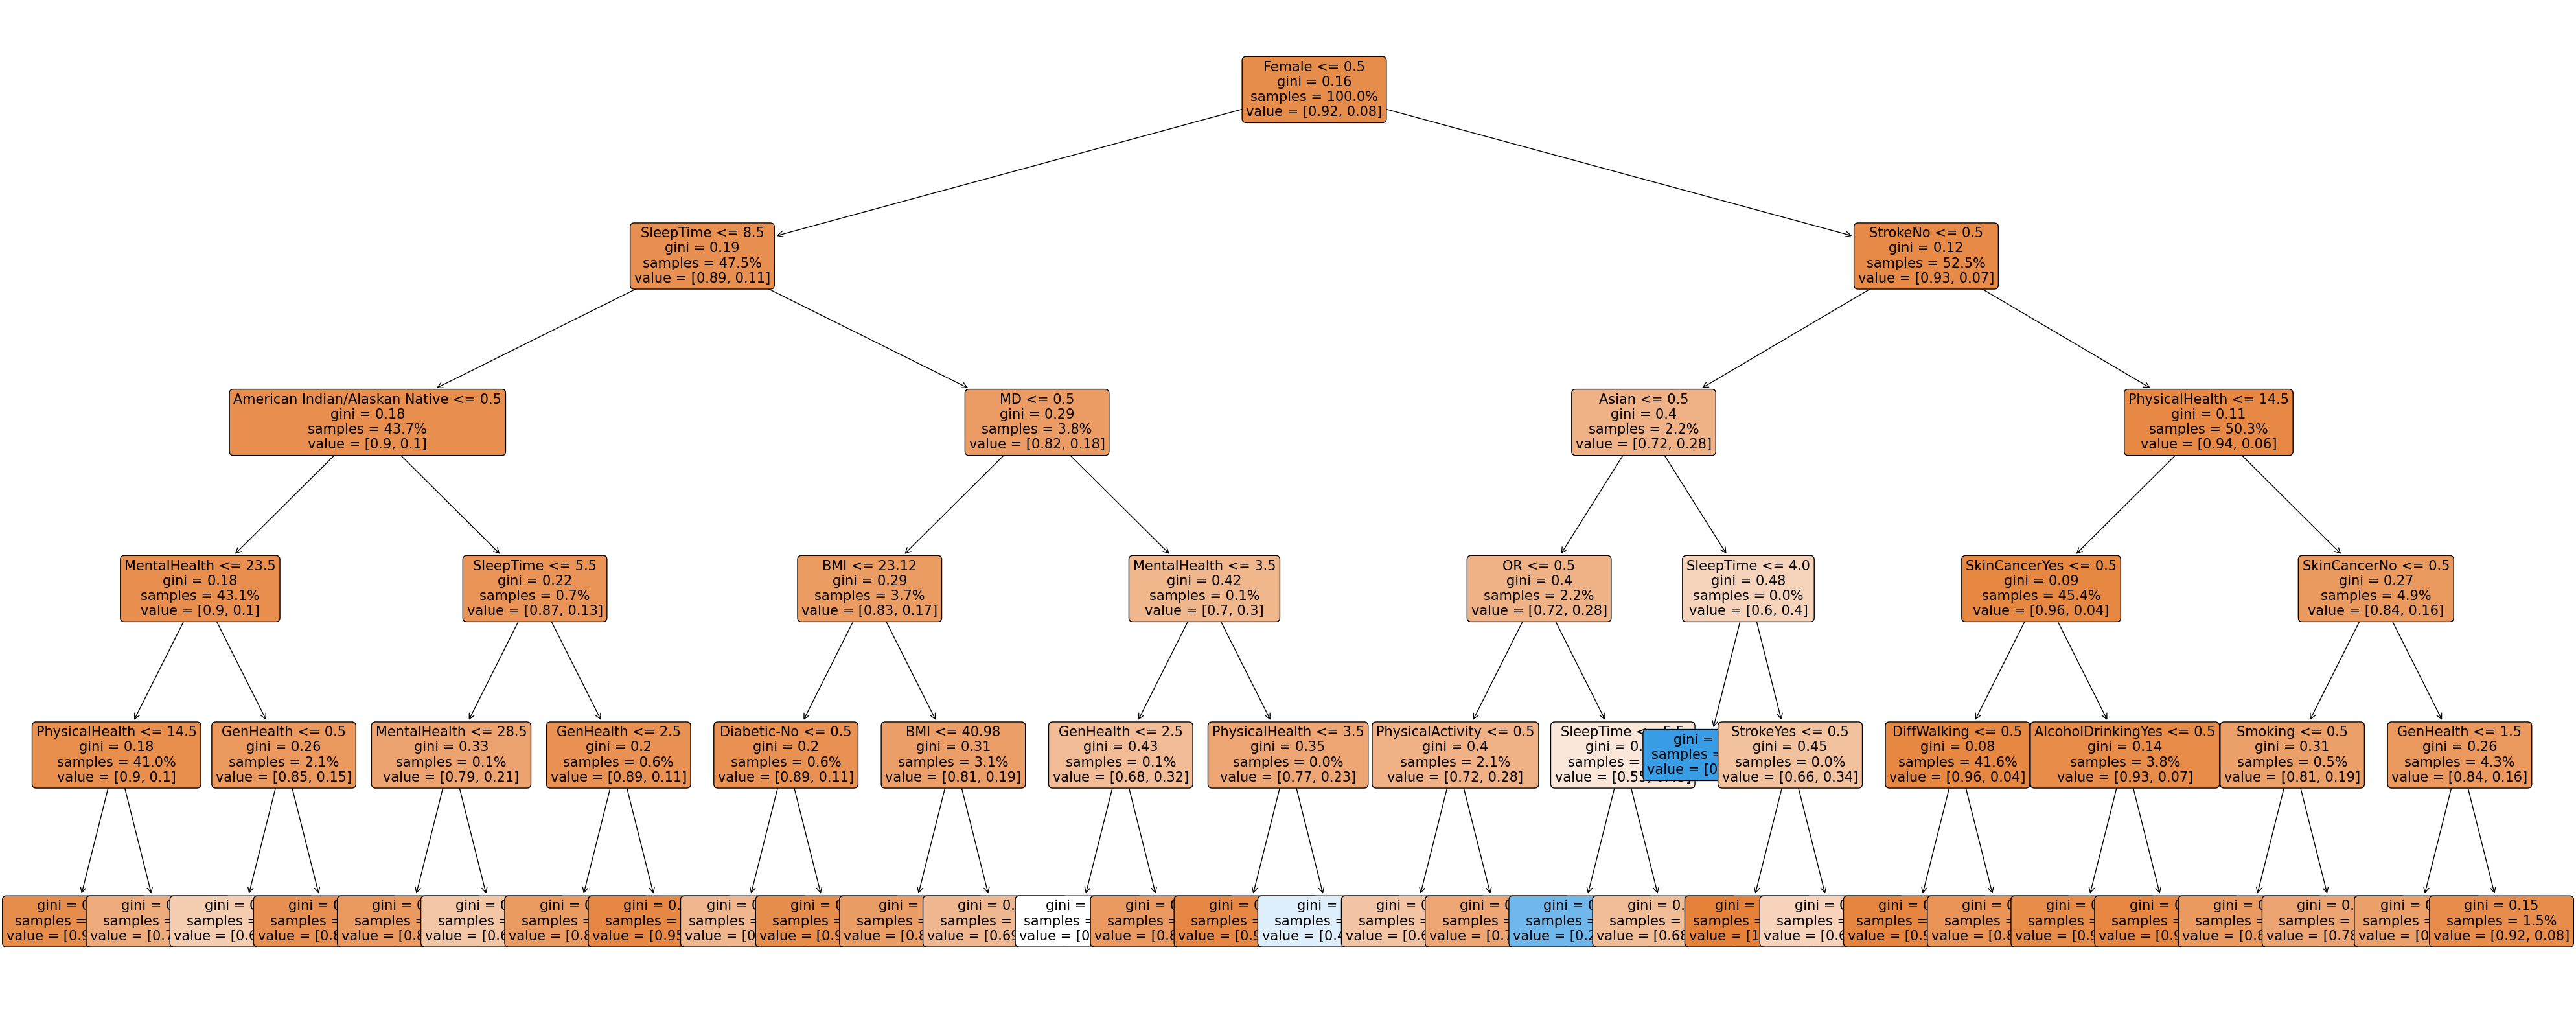

In [143]:
#visualize Random Forest
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(tree_list[0],
               ax = ax,
               fontsize = 15,
               proportion=True,
               filled = True,
               impurity=True,
               rounded = True,
               precision = 2,
               feature_names = feature_list
)

In [144]:
top_features = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
top_features

StrokeNo            0.230108
GenHealth           0.198377
PhysicalHealth      0.119401
AgeCategory         0.116525
KidneyDisease       0.051016
DiffWalking         0.048698
Diabetic-Yes        0.044731
Female              0.036596
Smoking             0.036438
Diabetic-No         0.034902
SleepTime           0.029730
Male                0.015609
PhysicalActivity    0.011481
MentalHealth        0.006522
BMI                 0.004769
SkinCancerYes       0.002991
StrokeYes           0.002502
Asthma              0.001824
SkinCancerNo        0.001359
OR                  0.001026
dtype: float64

The top featuresare slightly different than for the one tree we have, but GenHealth is still at the top

##### 3.4.2 Evaluation

In [145]:
results_rf = results_eval(rf, X_train, y_train)
results_rf.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [146]:
accuracy_train_rf, precision_train_rf, recall_train_rf, accuracy_test_rf, precision_test_rf, recall_test_rf = metr(rf, X_train, y_train, X_test, y_test)

Training Confusion Matrix: 
[[175581      1]
 [ 16285     10]]
TN = 175581 - FP = 1 - FN = 16285 - TP = 10

Training Metrics: 
Accuracy: 0.9151
Precision: 0.9091
Recall: 0.0006

Test Confusion Matrix: 
[[58470     3]
 [ 5486     0]]
TN = 58470 - FP = 3 - FN = 5486 - TP = 0

Test Metrics: 
Accuracy: 0.9142
Precision: 0.0000
Recall: 0.0000



This model has a very low Recall score, below 1% on the training set and 0% on the test set, and therefore will not be considered further. It is possible that this model misses many true positives, considering that there are only very few branches in the random forest that clearly predicts heart disease.

#### 3.5 Gradient Boosting Classifier

##### 3.5.1 Model building

In [147]:
#instantiate model. Set min_samples_split to 500 and n_estimators to 50 to prevent overfitting from the beginning and to make sure the model does not run too slow
gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

Text(0.5, 0, 'Gradient Boosting Feature Importance')

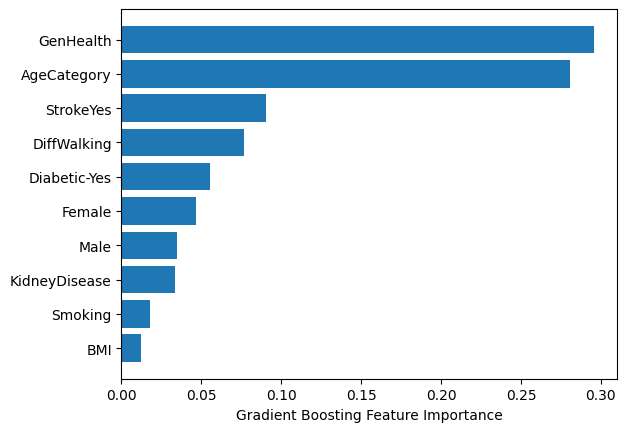

In [148]:
#show feature importance
sorted_idx = gb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], gb.feature_importances_[sorted_idx][-10:])
plt.xlabel("Gradient Boosting Feature Importance")

##### 3.5.2 Model evaluation

In [149]:
results_gb = results_eval(gb, X_train, y_train)
results_gb.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [150]:
accuracy_train_gb, precision_train_gb, recall_train_gb, accuracy_test_gb, precision_test_gb, recall_test_gb = metr(gb, X_train, y_train, X_test, y_test)

Training Confusion Matrix: 
[[174607    975]
 [ 14666   1629]]
TN = 174607 - FP = 975 - FN = 14666 - TP = 1629

Training Metrics: 
Accuracy: 0.9185
Precision: 0.6256
Recall: 0.1000

Test Confusion Matrix: 
[[58078   395]
 [ 5038   448]]
TN = 58078 - FP = 395 - FN = 5038 - TP = 448

Test Metrics: 
Accuracy: 0.9151
Precision: 0.5314
Recall: 0.0817



The Recall is 10.0% on the training set and 8.17% on the test set for this model, which is much better compared to the decision trees and random forest, but not as good as the one for the logistic regression.

##### 3.5.3 Model optimization

In [151]:
#check if test accuracy can be improved by increasing the max_depth from 5 to 6
gb2 = GradientBoostingClassifier(n_estimators=50, max_depth=6, min_samples_split=500, random_state=42)
gb2.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=6, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [152]:
results_gb2 = results_eval(gb2, X_train, y_train)
results_gb2.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [153]:
accuracy_train_gb, precision_train_gb, recall_train_gb, accuracy_test_gb, precision_test_gb, recall_test_gb = metr(gb2, X_train, y_train, X_test, y_test)

Training Confusion Matrix: 
[[174702    880]
 [ 14610   1685]]
TN = 174702 - FP = 880 - FN = 14610 - TP = 1685

Training Metrics: 
Accuracy: 0.9193
Precision: 0.6569
Recall: 0.1034

Test Confusion Matrix: 
[[58090   383]
 [ 5045   441]]
TN = 58090 - FP = 383 - FN = 5045 - TP = 441

Test Metrics: 
Accuracy: 0.9151
Precision: 0.5352
Recall: 0.0804



Increasing the maximum tree depth to 6 does not have a significant effect on the Recall metrics.

The results of all four models are summarized in a dataframe:

In [154]:
results_dict = {
    "Decision Tree": {"Test Accuracy":accuracy_test_dt, "Test Precision":precision_test_dt, "Test Recall":recall_test_dt},
    "Logistic Regression": {"Test Accuracy":accuracy_test_logr, "Test Precision":precision_test_logr, "Test Recall":recall_test_logr},
    "Random Forest": {"Test Accuracy":accuracy_test_rf, "Test Precision":precision_test_rf, "Test Recall":recall_test_rf},
    "Gradient Boost": {"Test Accuracy":accuracy_test_gb, "Test Precision":precision_test_gb, "Test Recall":recall_test_gb},
}

In [155]:
df_results = pd.DataFrame(results_dict).T
df_results

Test Accuracy  Test Precision  Test Recall
Decision Tree             0.915086        0.552581     0.052680
Logistic Regression       0.902484        0.406754     0.298578
Random Forest             0.914179        0.000000     0.000000
Gradient Boost            0.915133        0.535194     0.080386

All four models have pretty similar train and test Accuracy, between 90.2 and 91.5%.
The four models can be differentiated in terms of Recall scores: 29.87% and 8.03% for the logistic regression and the gradient boosting classifier respectively, compared to 5.27% and 0% for the other two models.
Therefore, the next step is to try and optimize both the logistic regression and the gradient boosting classifier further, the models with the higher Recall scores.

#### 3.6 Dimensionality reduction

##### 3.6.1 Logistic Regression

Only the 10 most important features will be selected, based on the feature importances by coefficients

In [156]:
high_coef = list(importances.head(5)['Attribute'])
high_coef

['AgeCategory', 'StrokeYes', 'KidneyDisease', 'BMI', 'Male']

In [157]:
low_coef= list(importances.tail(5)['Attribute'])
low_coef

['Asian', 'SleepTime', 'Female', 'StrokeUnknown', 'GenHealth']

In [158]:
#new test train split
X_train_test3, X_val3, y_train_test3, y_val3 = model_selection.train_test_split(
    df7[['AgeCategory', 'StrokeYes', 'KidneyDisease', 'Male', 'BMI', 'Asian', 'SleepTime', 'Female', 'StrokeUnknown', 'GenHealth']],
    df7['HeartDisease'],
    test_size=0.20,
    random_state=42
)

In [159]:
#split new test set
X_train3, X_test3, y_train3, y_test3 = model_selection.train_test_split(
    X_train_test3,
    y_train_test3,
    test_size=0.25,
    random_state=42
)

In [160]:
#build model
logr4 = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500, class_weight={1:0.7, 0:0.3})
logr4.fit(X=X_train3, y=y_train3)

LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=500, random_state=42)

In [161]:
results_logr4 = results_eval(logr4, X_train3, y_train3)
results_logr4.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        1        0
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [162]:
accuracy_train_logr4, precision_train_logr4, recall_train_logr4, accuracy_test_logr4, precision_test_logr4, recall_test_logr4 = metr(logr4, X_train3, y_train3, X_test3, y_test3)

Training Confusion Matrix: 
[[169288   6294]
 [ 11835   4460]]
TN = 169288 - FP = 6294 - FN = 11835 - TP = 4460

Training Metrics: 
Accuracy: 0.9055
Precision: 0.4147
Recall: 0.2737

Test Confusion Matrix: 
[[56343  2130]
 [ 3974  1512]]
TN = 56343 - FP = 2130 - FN = 3974 - TP = 1512

Test Metrics: 
Accuracy: 0.9046
Precision: 0.4152
Recall: 0.2756



The logistic regression could not be improved by reducing the features, the Recall even went down a bit, to 27.37% on the training set and 27.56% on the test set.

##### 3.6.2 Gradient Boosting Classifier

In [163]:
X_train.columns[sorted_idx][-10:]

Index(['BMI', 'Smoking', 'KidneyDisease', 'Male', 'Female', 'Diabetic-Yes',
       'DiffWalking', 'StrokeYes', 'AgeCategory', 'GenHealth'],
      dtype='object')

In [164]:
#new test train split with new features
X_train_test4, X_val4, y_train_test4, y_val4 = model_selection.train_test_split(
    df6[['BMI', 'Smoking', 'KidneyDisease', 'Female', 'Male', 'Diabetic-Yes',
       'DiffWalking', 'StrokeYes', 'AgeCategory', 'GenHealth']],
    df6['HeartDisease'],
    test_size=0.20,
    random_state=42
)

In [165]:
#split new test set
X_train4, X_test4, y_train4, y_test4 = model_selection.train_test_split(
    X_train_test4,
    y_train_test4,
    test_size=0.25,
    random_state=42
)

In [166]:
gb3 = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb3.fit(X_train4, np.ravel(y_train4))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [167]:
results_gb3 = results_eval(gb3, X_train4, y_train4)
results_gb3.head()

HeartDisease  HeartDisease Prediction  Success
197501             0                        0        1
74357              0                        0        1
202820             0                        0        1
59127              1                        0        0
253134             0                        0        1

In [168]:
accuracy_train_gb3, precision_train_gb3, recall_train_gb3, accuracy_test_gb3, precision_test_gb3, recall_test_gb3= metr(gb3, X_train4, y_train4, X_test4, y_test4)

Training Confusion Matrix: 
[[174635    947]
 [ 14825   1470]]
TN = 174635 - FP = 947 - FN = 14825 - TP = 1470

Training Metrics: 
Accuracy: 0.9178
Precision: 0.6082
Recall: 0.0902

Test Confusion Matrix: 
[[58117   356]
 [ 5075   411]]
TN = 58117 - FP = 356 - FN = 5075 - TP = 411

Test Metrics: 
Accuracy: 0.9151
Precision: 0.5359
Recall: 0.0749



By reducing the features the gradient boosting classifier could not be improved, either.

#### 3.7 Resampling

##### 3.7.2 Logistic Regression

Model building

In [169]:
#check how many 1s the training data contains
y_train2[y_train2>0].shape

(16295,)

In [170]:
#check how many 0s the training data contains
y_train2[y_train2==0].shape

(175582,)

In [171]:
print("Current precentage of samples with heart disease = 1: ", 16295/(16295+175582)*100,"%")

Current precentage of samples with heart disease = 1:  8.492419622987644 %


In [172]:
print("For the precentage to be around 10%, the number of samples with heart disease = 0 needs to be reduced to",16295*10)

For the precentage to be around 10%, the number of samples with heart disease = 0 needs to be reduced to 162950


In [173]:
#add target column to x training data
X_train2['HeartDisease'] = y_train2
X_train2_zeros = X_train2[X_train2['HeartDisease']==0]
X_train2_nonzeros = X_train2[X_train2['HeartDisease']==1]

In [174]:
#resample nonzeros in dataset
X_train2_zeros_sample = X_train2_zeros.sample(n= 162950, random_state=42)
X_train2_zeros_sample.head()

BMI  Smoking  PhysicalHealth  MentalHealth  DiffWalking  \
310530  0.461172        1        0.000000      0.000000            0   
137524  0.236541        1        0.000000      0.033333            0   
32822   0.221296        1        0.000000      0.100000            0   
267807  0.135779        0        0.166667      0.100000            0   
124453  0.162220        1        0.133333      0.066667            1   

        AgeCategory  PhysicalActivity  GenHealth  SleepTime  Asthma  \
310530     0.866667                 1       0.50   0.357143       1   
137524     0.700000                 1       1.00   0.428571       0   
32822      0.866667                 1       0.75   0.428571       1   
267807     0.016667                 1       0.25   0.642857       0   
124453     0.700000                 1       0.25   0.785714       0   

        KidneyDisease  AlcoholDrinkingNo  AlcoholDrinkingUnknown  \
310530              0                  0                       1   
137524              0                  0                       1   
32822               0                  1                       0   
267807              0                  1                       0   
124453              0                  1                       0   

        AlcoholDrinkingYes  StrokeNo  StrokeUnknown  StrokeYes  SkinCancerNo  \
310530                   0         1              0          0             0   
137524                   0         1              0          0             1   
32822                    0         1              0          0             0   
267807                   0         1              0          0             1   
124453                   0         1              0          0             1   

        SkinCancerUnknown  SkinCancerYes  Female  Male  HeartDisease_FamilyNo  \
310530                  0              1       0     1                      0   
137524                  0              0       1     0                      0   
32822                   0              1       1     0                      1   
267807                  0              0       0     1                      0   
124453                  0              0       0     1                      0   

        HeartDisease_FamilyUnknown  HeartDisease_FamilyYes  \
310530                           1                       0   
137524                           1                       0   
32822                            0                       0   
267807                           1                       0   
124453                           1                       0   

        American Indian/Alaskan Native  Asian  Black  Hispanic  Race-Other  \
310530                               0      0      0         0           0   
137524                               0      0      0         0           0   
32822                                0      0      0         0           0   
267807                               0      0      0         1           0   
124453                               0      0      1         0           0   

        White  Diabetic-No  Diabetic-No, borderline  Diabetic-Yes  \
310530      1            1                        0             0   
137524      1            1                        0             0   
32822       1            1                        0             0   
267807      0            1                        0             0   
124453      0            0                        0             1   

        Diabetic-Yes (during pregnancy)  AK  AL  AR  AZ  CA  CO  CT  DC  DE  \
310530                                0   0   0   0   0   0   0   0   0   0   
137524                                0   0   0   0   0   0   0   0   0   0   
32822                                 0   0   0   0   0   0   0   0   0   0   
267807                                0   0   0   0   0   0   0   0   0   0   
124453                                0   0   0   0   0   0   0   0   0   0   

        FL  GA  HI  IA  ID  IL  IN  KS  KY  

In [175]:
#concat resampled non-zeros and zeros to new training dataset
X_train2_undersampled = pd.concat([X_train2_nonzeros, X_train2_zeros_sample], axis=0)

In [176]:
#save target as new y training data
y_train2_undersampled = X_train2_undersampled['HeartDisease']

In [177]:
#drop target from x training data
X_train2_undersampled.drop('HeartDisease', axis=1, inplace=True)

In [178]:
print("Percentage of 1s in the new training dataset:", 16295/162950*100, "%")

Percentage of 1s in the new training dataset: 10.0 %


In [179]:
#fit new model
logr5 = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500, class_weight={1:0.7, 0:0.3})
logr5.fit(X=X_train2_undersampled, y=y_train2_undersampled)

LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=500, random_state=42)

Model evaluation

In [180]:
results_logr5 = results_eval(logr5, X_train2_undersampled, y_train2_undersampled)
results_logr5.head()

HeartDisease  HeartDisease Prediction  Success
59127              1                        0        0
68898              1                        0        0
151423             1                        0        0
106554             1                        0        0
38250              1                        0        0

In [181]:
accuracy_train_logr5, precision_train_logr5, recall_train_logr5, accuracy_test_logr5, precision_test_logr5, recall_test_logr5 = metr(logr5, X_train2_undersampled, y_train2_undersampled, X_test2, y_test2)

Training Confusion Matrix: 
[[155683   7267]
 [ 10902   5393]]
TN = 155683 - FP = 7267 - FN = 10902 - TP = 5393

Training Metrics: 
Accuracy: 0.8986
Precision: 0.4260
Recall: 0.3310

Test Confusion Matrix: 
[[55764  2709]
 [ 3703  1783]]
TN = 55764 - FP = 2709 - FN = 3703 - TP = 1783

Test Metrics: 
Accuracy: 0.8997
Precision: 0.3969
Recall: 0.3250



With Resampling the test Recall score could be improved further (32.50%), the test Accuracy drops slightly (89.97%).

##### 3.7.3 GradientBoostingClassifier

Model Building

In [182]:
#add target column to x training data
X_train['HeartDisease'] = y_train
X_train_zeros = X_train[X_train['HeartDisease']==0]
X_train_nonzeros = X_train[X_train['HeartDisease']==1]

In [183]:
#resample nonzeros in dataset
X_train_zeros_sample = X_train_zeros.sample(n= 162950, random_state=42)
X_train_zeros_sample.head()

BMI  Smoking  PhysicalHealth  MentalHealth  DiffWalking  \
310530  31.38        1             0.0           0.0            0   
137524  21.95        1             0.0           1.0            0   
32822   21.31        1             0.0           3.0            0   
267807  17.72        0             5.0           3.0            0   
124453  18.83        1             4.0           2.0            1   

        AgeCategory  PhysicalActivity  GenHealth  SleepTime  Asthma  \
310530         72.0                 1          2        6.0       1   
137524         62.0                 1          4        7.0       0   
32822          72.0                 1          3        7.0       1   
267807         21.0                 1          1       10.0       0   
124453         62.0                 1          1       12.0       0   

        KidneyDisease  AlcoholDrinkingNo  AlcoholDrinkingUnknown  \
310530              0                  0                       1   
137524              0                  0                       1   
32822               0                  1                       0   
267807              0                  1                       0   
124453              0                  1                       0   

        AlcoholDrinkingYes  StrokeNo  StrokeUnknown  StrokeYes  SkinCancerNo  \
310530                   0         1              0          0             0   
137524                   0         1              0          0             1   
32822                    0         1              0          0             0   
267807                   0         1              0          0             1   
124453                   0         1              0          0             1   

        SkinCancerUnknown  SkinCancerYes  Female  Male  HeartDisease_FamilyNo  \
310530                  0              1       0     1                      0   
137524                  0              0       1     0                      0   
32822                   0              1       1     0                      1   
267807                  0              0       0     1                      0   
124453                  0              0       0     1                      0   

        HeartDisease_FamilyUnknown  HeartDisease_FamilyYes  \
310530                           1                       0   
137524                           1                       0   
32822                            0                       0   
267807                           1                       0   
124453                           1                       0   

        American Indian/Alaskan Native  Asian  Black  Hispanic  Race-Other  \
310530                               0      0      0         0           0   
137524                               0      0      0         0           0   
32822                                0      0      0         0           0   
267807                               0      0      0         1           0   
124453                               0      0      1         0           0   

        White  Diabetic-No  Diabetic-No, borderline  Diabetic-Yes  \
310530      1            1                        0             0   
137524      1            1                        0             0   
32822       1            1                        0             0   
267807      0            1                        0             0   
124453      0            0                        0             1   

        Diabetic-Yes (during pregnancy)  AK  AL  AR  AZ  CA  CO  CT  DC  DE  \
310530                                0   0   0   0   0   0   0   0   0   0   
137524                                0   0   0   0   0   0   0   0   0   0   
32822                                 0   0   0   0   0   0   0   0   0   0   
267807                                0   0   0   0   0   0   0   0   0   0   
124453                                0   0   0   0   0   0   0   0   0   0   

        FL  GA  HI  IA  ID  IL  IN  KS  KY  LA  MA  MD  ME 

In [184]:
#concat resampled non-zeros and zeros to new training dataset
X_train_undersampled = pd.concat([X_train_nonzeros, X_train_zeros_sample], axis=0)

In [185]:
#save target as new y training data
y_train_undersampled = X_train_undersampled['HeartDisease']

In [186]:
#drop target from x training data
X_train_undersampled.drop('HeartDisease', axis=1, inplace=True)

In [187]:
#train new model
gb4 = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb4.fit(X_train_undersampled, np.ravel(y_train_undersampled))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [188]:
#evaluate results
results_gb4 = results_eval(gb4, X_train_undersampled, y_train_undersampled)
results_gb4.head()

HeartDisease  HeartDisease Prediction  Success
59127              1                        0        0
68898              1                        0        0
151423             1                        0        0
106554             1                        0        0
38250              1                        0        0

In [189]:
accuracy_train_gb4, precision_train_gb4, recall_train_gb4, accuracy_test_gb4, precision_test_gb4, recall_test_gb4 = metr(gb4, X_train_undersampled, y_train_undersampled, X_test, y_test)

Training Confusion Matrix: 
[[161851   1099]
 [ 14437   1858]]
TN = 161851 - FP = 1099 - FN = 14437 - TP = 1858

Training Metrics: 
Accuracy: 0.9133
Precision: 0.6283
Recall: 0.1140

Test Confusion Matrix: 
[[58011   462]
 [ 4968   518]]
TN = 58011 - FP = 462 - FN = 4968 - TP = 518

Test Metrics: 
Accuracy: 0.9151
Precision: 0.5286
Recall: 0.0944



With Resampling the test Recall score for the gradient boosting classifier could be improved, as well, to 9.44%. However, the logistic regression remains the best model performing model, with a maximum test Recall score of 32.50%. In order for this model to be used in the real world the Recall score would need to be even higher, though. Right now, the model recognizes a bit less than one third of people with heart disease as such.

#### 3.8 Reverse outlier treatment in Age column

Before dealing with the outliers the Age column contained several values equal to 0, which were clipped to 20. This will now be reverted, instead, these values are replaced with the median age.  

First, we search for the median and minimum values in the training data used for the logistic regression.

In [190]:
median_scaled = X_train2_undersampled['AgeCategory'].median()
median_scaled

0.6166666666666667

In [191]:
min_scaled = X_train2_undersampled['AgeCategory'].min()
min_scaled

0.0

The median value is 0.6167, the minimum value 0.0

Next, we search for the median and minimum value in the training data used for the gradient boosting classifier.

In [192]:
median_not_scaled = X_train_undersampled['AgeCategory'].median()
median_not_scaled

57.0

In [193]:
min_not_scaled = X_train_undersampled['AgeCategory'].min()
min_not_scaled

20.0

The median value here is 57.0, the minimum value is 20 (the one that was used for clipping the outliers).

Copy both training and test datasets and then replace minimum values with median values.

In [194]:
X_train_undersampled_new = X_train_undersampled.copy()
X_train2_undersampled_new = X_train2_undersampled.copy()
X_test_new = X_test.copy()
X_test2_new = X_test2.copy()

In [195]:
X_train_undersampled_new['AgeCategory'] = X_train_undersampled_new['AgeCategory'].replace(min_not_scaled, median_not_scaled)
X_train2_undersampled_new['AgeCategory'] = X_train2_undersampled_new['AgeCategory'].replace(min_scaled, median_scaled)
X_test_new['AgeCategory'] = X_test_new['AgeCategory'].replace(min_not_scaled, median_not_scaled)
X_test2_new['AgeCategory'] = X_test2_new['AgeCategory'].replace(min_scaled, median_scaled)

After the changes the minimum values are checked again:

In [196]:
X_train2_undersampled_new['AgeCategory'].min()

0.016666666666666663

In [197]:
X_test2_new['AgeCategory'].min()

0.016666666666666663

In [198]:
X_train_undersampled_new['AgeCategory'].min()

21.0

In [199]:
X_test_new['AgeCategory'].min()

21.0

Now they are no longer 0.0 and 20, the replacement was done correctly.

##### 3.8.1 Logistic Regression

In [200]:
#fit new model
logr6 = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500, class_weight={1:0.7, 0:0.3})
logr6.fit(X=X_train2_undersampled_new, y=y_train2_undersampled)

LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=500, random_state=42)

In [201]:
results_logr6 = results_eval(logr6, X_train2_undersampled_new, y_train2_undersampled)
results_logr6.head()

HeartDisease  HeartDisease Prediction  Success
59127              1                        0        0
68898              1                        0        0
151423             1                        0        0
106554             1                        0        0
38250              1                        0        0

In [202]:
accuracy_train_logr6, precision_train_logr6, recall_train_logr6, accuracy_test_logr6, precision_test_logr6, recall_test_logr6 = metr(logr6, X_train2_undersampled_new, y_train2_undersampled, X_test2_new, y_test2)

Training Confusion Matrix: 
[[155682   7268]
 [ 10899   5396]]
TN = 155682 - FP = 7268 - FN = 10899 - TP = 5396

Training Metrics: 
Accuracy: 0.8986
Precision: 0.4261
Recall: 0.3311

Test Confusion Matrix: 
[[55762  2711]
 [ 3701  1785]]
TN = 55762 - FP = 2711 - FN = 3701 - TP = 1785

Test Metrics: 
Accuracy: 0.8997
Precision: 0.3970
Recall: 0.3254



The outlier treatment reversal has little to no effect on the metrics, the test Recall only goes up by 0.4%, from 32.50 to 32.54%.

##### 3.8.2 Gradient Boosting Classifier

In [203]:
#train new model
gb5 = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb5.fit(X_train_undersampled_new, np.ravel(y_train_undersampled))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [204]:
#evaluate results
results_gb5 = results_eval(gb5, X_train_undersampled_new, y_train_undersampled)
results_gb5.head()

HeartDisease  HeartDisease Prediction  Success
59127              1                        0        0
68898              1                        0        0
151423             1                        0        0
106554             1                        0        0
38250              1                        0        0

In [205]:
accuracy_train_gb5, precision_train_gb5, recall_train_gb5, accuracy_test_gb5, precision_test_gb5, recall_test_gb5 = metr(gb5, X_train_undersampled_new, y_train_undersampled, X_test_new, y_test)

Training Confusion Matrix: 
[[161852   1098]
 [ 14418   1877]]
TN = 161852 - FP = 1098 - FN = 14418 - TP = 1877

Training Metrics: 
Accuracy: 0.9134
Precision: 0.6309
Recall: 0.1152

Test Confusion Matrix: 
[[58002   471]
 [ 4958   528]]
TN = 58002 - FP = 471 - FN = 4958 - TP = 528

Test Metrics: 
Accuracy: 0.9151
Precision: 0.5285
Recall: 0.0962



The effect on the test Recall value of the Gradient Boost Classifier is also mininmal, it goes up from 9.44% to 9.62%.

#### 3.9 Conclusion

The final results of the optimized logistic regression and gradient boosting classifier are summarized in a dataframe:

In [206]:
results_dict2 = {
    "Logistic Regression": {"Test Accuracy":accuracy_test_logr6, "Test Precision":precision_test_logr6, "Test Recall":recall_test_logr6},
    "Gradient Boost": {"Test Accuracy":accuracy_test_gb5, "Test Precision":precision_test_gb5, "Test Recall":recall_test_gb5},
}

In [207]:
df_results2 = pd.DataFrame(results_dict2).T
df_results2

Test Accuracy  Test Precision  Test Recall
Logistic Regression       0.899748        0.397020     0.325374
Gradient Boost            0.915117        0.528529     0.096245

Even though the gradient boosting classifier has the higher overall test Accuracy the recommendation would be to select the logistic regression as the final model since it has the better Recall score, meaning it is better at identifying true positives and would identify more respondents that have a heart disease as such. The test accuracy of this model is still around 90%, which confirms that there is no overfitting on the training set.

However, it is important to mention that the model could be used to support medical diagnoses or to give a first idea about the overall likelihood of someone having a heart disease, but it should never be the only method used as it only identifies about one third of patients with a heart disease as such.